In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr 
#from statsmodels.tsa.stattools import acf
from sklearn import preprocessing
from collections import defaultdict
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.sparse import vstack, hstack, save_npz, load_npz
import json
import datetime

### t-Test (UE vs U)

In [80]:
from scipy import stats
res_user_probTopic = np.loadtxt('accuracies_model_user_probTopic.txt')
res_user_event = np.loadtxt('accuracies_model_user_event.txt')

print('Topic, K = 100')
print(np.mean(res_user_probTopic))
print(np.mean(res_user_event))
stats.ttest_ind(res_user_probTopic,res_user_event, equal_var = False)

#stats.wilcoxon(res_user_probTopic,res_user_event)

Topic, K = 100
0.8052102102102103
0.8196955826794536


Ttest_indResult(statistic=-170.75266054052776, pvalue=2.401210585080078e-223)

In [81]:
res_user_probTopic = np.loadtxt('accuracies_model_user_probTopic.txt')
res_user_event = np.loadtxt('accuracies_model_user_event.txt')

stats.wilcoxon(res_user_probTopic,res_user_event)

WilcoxonResult(statistic=0.0, pvalue=1.4310781332509736e-34)

### Cohen's d (UE vs U)

In [82]:
def compute_cohen_d(top1, top50):
    cohens_d = (np.mean(top1) - np.mean(top50)) / (np.sqrt((np.std(top1) ** 2 + np.std(top50) ** 2) / 2))

    return cohens_d

print("Cohen's d ", compute_cohen_d(res_user_event, res_user_probTopic))

Cohen's d  17.118114969741075


### Number of posts per user samped during bootstrap

In [83]:
num_of_posts = np.loadtxt('num_posts_sample_user.txt')
S, U = num_of_posts.shape

for i in range(S):
    for j in range(U):
        if num_of_posts[i,j] < 16:
            print(i,j)

### Identifying users with positive feedback effect

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(200, 32623)
(200, 6882)
mean 0.495745606291145
std 0.19033086637873714
[1.24476103 1.01534775 2.45172325 ... 0.88293999 0.9167676  2.03920903]
95 percentile score  3.3988898953255458
Number of users with positive FB 786 0.11421098517872712
0.2950490712129563
Number of users with negative FB 90 0.013077593722755012
6006
Number of users that have neither pos or neg FB 6006 0.8727114210985178
Top pos users 0.11421098517872712


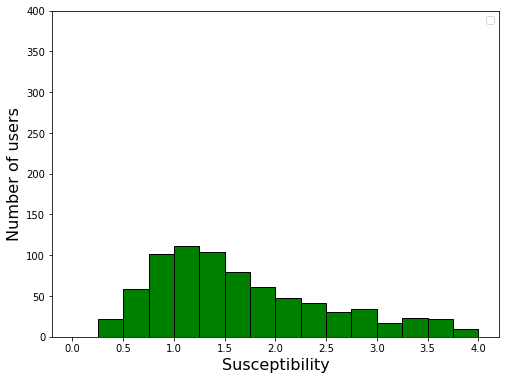

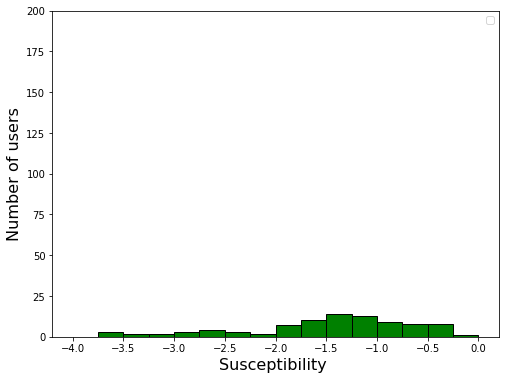

In [122]:
no_user = 6882 #6902
user_idx = no_user

def identifying_positive_users(feedback_defn):
    
    data_coef = load_npz('bootstraps_coefs_LDA100_'+feedback_defn+'.npz')
    data_coef = data_coef.toarray()
    print(data_coef.shape)

    data = data_coef[:,:no_user]
    print(data.shape)


    median_fb = np.median(data, axis=0)
    mean_fb = np.mean(data, axis=0)

    print('mean', np.mean(mean_fb))
    print('std', 2.58*np.std(mean_fb)/np.sqrt(200))



    err_ci = (np.percentile(data, 99.5, axis=0)- np.percentile(data, 0.5, axis=0))/2.0
    print(err_ci)
    top_users_score = np.percentile(median_fb, 99)
    print('95 percentile score ', np.percentile(median_fb, 99))
    median_fb_pos = median_fb - err_ci
    median_fb_neg = median_fb + err_ci


    pos_fb_idx = np.where(median_fb_pos > 0.0)[0]
    no_with_pos_fb = len(pos_fb_idx)
    pos_fb = median_fb[pos_fb_idx]
    print('Number of users with positive FB', no_with_pos_fb, no_with_pos_fb/no_user)
    print(np.min(pos_fb))

    neg_fb_idx = np.where(median_fb_neg < -0.0)[0]
    no_with_neg_fb = len(neg_fb_idx)
    neg_fb = median_fb[neg_fb_idx]
    print('Number of users with negative FB', no_with_neg_fb, no_with_neg_fb/no_user)

    other_idx = list(set(list(range(no_user))) - (set(pos_fb_idx) | set(neg_fb_idx)))
    print(len(other_idx))
    no_others = len(median_fb)-no_with_pos_fb-no_with_neg_fb
    print('Number of users that have neither pos or neg FB',no_others, no_others/no_user)

    print('Top pos users', no_with_pos_fb/len(median_fb_pos))

    fig = plt.figure()
    fig.set_size_inches(8, 6)
    #plt.title("Positive users ", fontsize = 16)
    plt.ylim(0, 400)
    plt.hist(pos_fb, align='mid', cumulative=False,  bins=16, color='g', range=(0,4.0), histtype='bar', ec='k')     
    #plt.ylabel('PDF', fontsize = 16)
    plt.ylabel('Number of users', fontsize = 16)
    plt.xlabel('Susceptibility', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('twitter_'+feedback_defn+'_users_pos_no.eps', format='eps', dpi=1000)


    fig = plt.figure()
    fig.set_size_inches(8, 6)
    #plt.title("Negative users ", fontsize = 16)
    plt.ylim(0, 200)
    plt.hist(neg_fb, align='mid', cumulative=False, bins=16, color='g', range=(-4.0, 0), histtype='bar', ec='k')     
    #plt.ylabel('PDF', fontsize = 16)
    plt.ylabel('Number of users', fontsize = 16)
    plt.xlabel('Susceptibility ', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('twitter_'+feedback_defn+'_users_neg_no.eps', format='eps', dpi=1000)
    
    return pos_fb_idx, neg_fb_idx, other_idx, median_fb, median_fb_pos, median_fb_neg

pos_fb_idx, neg_fb_idx, other_idx, median_fb, median_fb_pos, median_fb_neg = identifying_positive_users('favdt')
#pos_fb_idx, neg_fb_idx, other_idx, median_fb, median_fb_pos, median_fb_neg = identifying_positive_users('pudt')


### Plot Topic trends from Inferred Parameters

No handles with labels found to put in legend.


(3, 25083)
19 [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 64, 65, 66]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


43 [153, 154, 155, 156, 157, 158, 159, 160, 170, 171, 172, 173, 174, 175, 49, 50, 51, 52, 177, 178, 179, 180, 181, 76, 77, 78, 79, 80, 124, 125, 126, 127]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


56 [141, 142, 143, 162, 163, 164, 43, 44, 45, 46, 176, 177, 178, 71, 72, 73, 92, 93, 94, 120, 121, 122, 123]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# topics with 3 consecutive positive betas  3


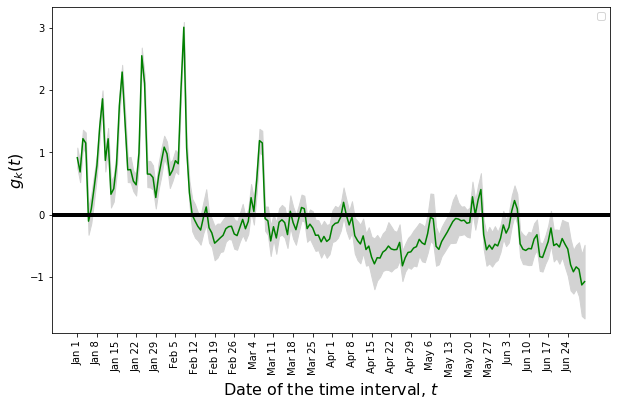

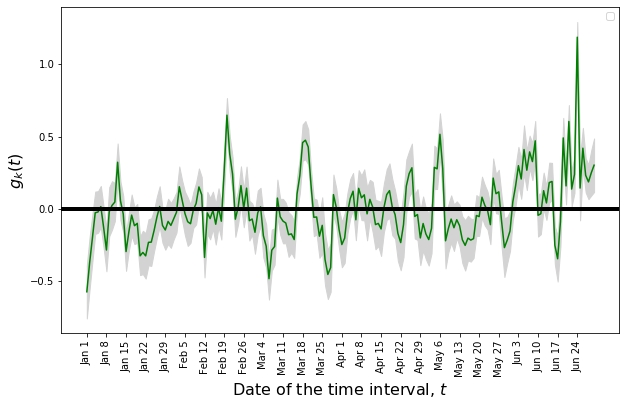

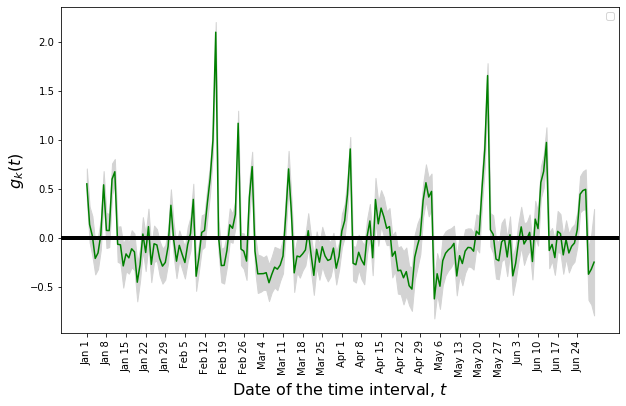

In [123]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)

no_user = 6882 
user_idx = no_user+1
j=0

data = np.loadtxt('model_parameters_model_user_eventmedian.txt')
res = data[0]
res_error =data[1]
print(data.shape)
no_topics = 100
topic_time_evt_matrix = res[user_idx:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[user_idx:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = topic_time_evt_matrix_std * 1.96/2.58
topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

binc=1
imp_topics = [19, 43, 56]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits = []
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        #print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        event_like_idxs = list(set(np.array(result_idx).flatten()))
        print(top, event_like_idxs)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    #identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    #plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    #plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    #plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)
    
    plt.ylabel(r'$g_k(t)$', fontsize = 16)
    plt.xlabel('Date of the time interval, 'r'$t$', fontsize = 16)

    time_intervals = np.array(list(range(N)))
    #plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    plt.plot(time_intervals, res, linestyle='-', color='g')
    #plt.plot(time_intervals[event_like_idxs], res[event_like_idxs], linestyle='None', marker='o', color='g')
    plt.fill_between(time_intervals, res-error, res+error, color='lightgrey')

    

    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('Twitter_ue_beta_topic'+str(top)+'.png', bbox_inches='tight')
    plt.savefig('Twitter_ue_beta_topic'+str(top)+'.eps', format='eps', dpi=1000)
    


print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
for sub in identified_subreddits:
    print(sub)                                            
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

### Plot Topic trends from number of posts

No handles with labels found to put in legend.


100
dict_keys(['65', '93', '55', '32', '19', '62', '97', '95', '4', '9', '11', '41', '81', '69', '23', '70', '16', '13', '63', '0', '87', '78', '91', '90', '35', '39', '96', '92', '14', '73', '31', '38', '3', '83', '75', '25', '21', '50', '24', '36', '43', '60', '53', '56', '26', '76', '77', '2', '74', '85', '27', '6', '54', '99', '44', '15', '28', '86', '7', '5', '66', '94', '88', '61', '29', '42', '40', '52', '33', '80', '98', '47', '45', '30', '17', '71', '49', '51', '18', '37', '46', '67', '48', '34', '84', '57', '8', '12', '58', '1', '68', '10', '64', '59', '72', '22', '82', '89', '20', '79'])
19 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


43 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


56 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


# topics with 3 consecutive positive betas  3


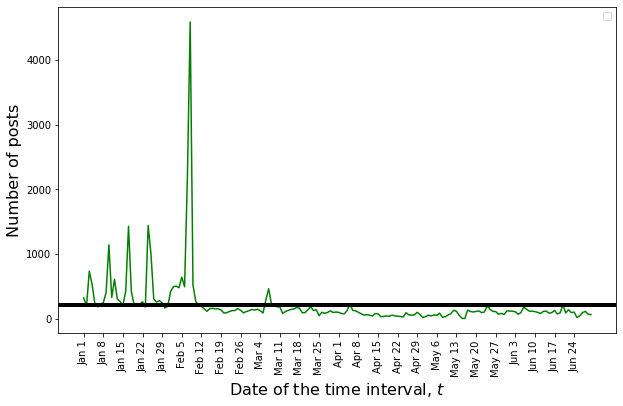

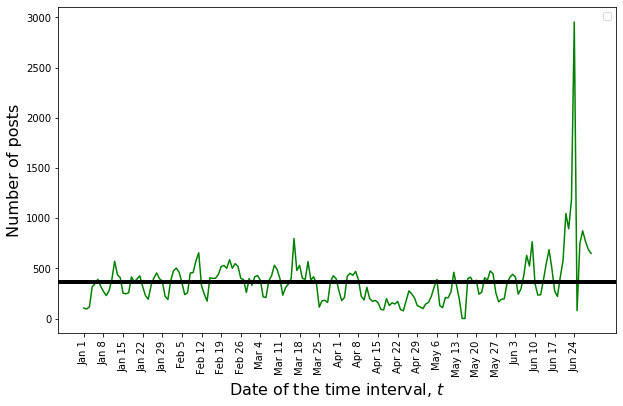

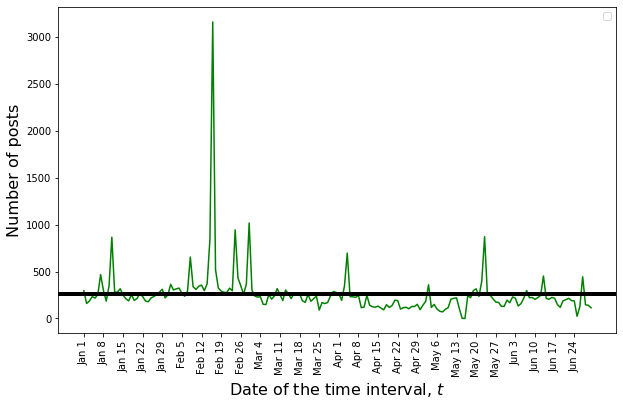

In [124]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)


with open('num_of_posts_by_timebin_topic.json', 'r') as fp:
    num_of_post_per_k_t = json.load(fp)
    
print(len(num_of_post_per_k_t))
print(num_of_post_per_k_t.keys())
    
topic_time_evt_matrix = np.zeros((100, 182))
for topic in num_of_post_per_k_t:
    for timebin in num_of_post_per_k_t[topic]:
        k, t = int(topic), int(timebin)
        topic_time_evt_matrix[k][t] = num_of_post_per_k_t[topic][timebin]
        

topic_time_evt_matrix_mean = np.mean(topic_time_evt_matrix, axis=1)
        
#topic_time_evt_matrix = preprocessing.scale(topic_time_evt_matrix, axis=1, with_std=False)


jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = [19, 43, 56]
#imp_topics = [21, 44, 59]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
identified_subreddits = []
j=0
binc=1
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    #error = topic_time_evt_matrix_std[top]

    res_min_error = res
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        #print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        event_like_idxs = list(set(np.array(result_idx).flatten()))
        print(top, event_like_idxs)
    else:
        continue
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    #identified_subreddits.append(dict_id_subreddit[dict_topicId_subId[top]])
    #plt.title('Subreddit: '+dict_id_subreddit[dict_topicId_subId[top]])
    #plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    #plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)
    
    plt.ylabel('Number of posts', fontsize = 16)
    plt.xlabel('Date of the time interval, 'r'$t$', fontsize = 16)

    time_intervals = np.array(list(range(N)))
    #plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    plt.plot(time_intervals, res, linestyle='-', color='g')
    #plt.plot(time_intervals[event_like_idxs], res[event_like_idxs], linestyle='None', marker='o', color='g')
    #plt.fill_between(time_intervals, res-error, res+error, color='lightgrey')
    

    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(y=topic_time_evt_matrix_mean[top], linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('data_twitter_ue_beta_topic'+str(top)+'.png', bbox_inches='tight')
    plt.savefig('data_twitter_ue_beta_topic'+str(top)+'.eps', format='eps', dpi=1000)
    


print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
for sub in identified_subreddits:
    print(sub)                                            
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])

### Gain of topic repeat probability between top1 and top50 percentile

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


(2, 6882)
0.022860609229824934 0.0027025939979087093 0.07377059381043924
0.0191003762944031 0.0031468996683624794 0.07805391086243889
median gain in probability 0.01743067796746822
fraction more than 10% 0.031806615776081425


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


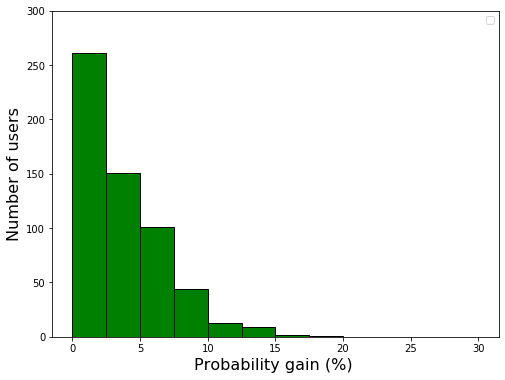

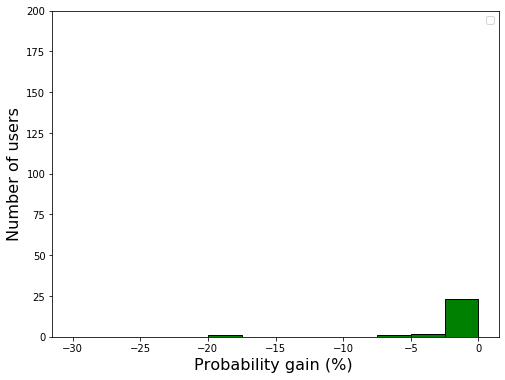

In [125]:
data = np.loadtxt('diff_in_prob_1_50_LDA100_pudt.txt')
print(data.shape)
'''
with open('users_topics.json', 'r') as fp:
    users_topics = json.load(fp)
    
def compute_min_max_median(indexes):
    min_val = np.zeros(len(indexes))
    max_val = np.zeros(len(indexes))
    median_val = np.zeros(len(indexes))
    for i, u in enumerate(indexes):
        min_val[i] = np.min(data[u][users_topics[str(u)]])
        max_val[i] = np.max(data[u][users_topics[str(u)]])
        median_val[i] = np.median(data[u][users_topics[str(u)]])

    err_min_ci = (np.percentile(min_val, 99.5, axis=0)- np.percentile(min_val, 0.5, axis=0))/2.0
    err_max_ci = (np.percentile(max_val, 99.5, axis=0)- np.percentile(max_val, 0.5, axis=0))/2.0
    err_median_ci = (np.percentile(median_val, 99.5, axis=0)- np.percentile(median_val, 0.5, axis=0))/2.0
    print('median, min, err', np.median(min_val), err_min_ci)
    print('median, max, err', np.median(max_val), err_max_ci)
    print('median, median, err', np.median(median_val), err_median_ci)
    
print('positive users')
compute_min_max_median(pos_fb_idx)
print('negative users')
compute_min_max_median(neg_fb_idx)

'''

pos_fb = data[0][pos_fb_idx]
print(np.mean(pos_fb), np.std(pos_fb)/14, (np.percentile(pos_fb, 97.5, axis=0)- np.percentile(pos_fb, 2.5, axis=0))/2.0)
neg_fb = data[0][neg_fb_idx]
print(np.mean(neg_fb), np.std(neg_fb)/14, (np.percentile(neg_fb, 97.5, axis=0)- np.percentile(neg_fb, 2.5, axis=0))/2.0)

print('median gain in probability', np.median(pos_fb))
print('fraction more than 10%', len(np.where(pos_fb > 0.1)[0])/len(pos_fb))


fig = plt.figure()
fig.set_size_inches(8, 6)
plt.ylim(0, 300)
#plt.title("Positive users ", fontsize = 16)
plt.hist(pos_fb*100, align='mid', cumulative=False, bins=12, color='g', range=(0.0, 30), histtype='bar', ec='k')     
plt.ylabel('Number of users', fontsize = 16)
#plt.ylabel('PDF', fontsize = 16)
plt.xlabel('Probability gain (%) ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('twitter_diff_1_50_topFb_posUsers_no.eps', format='eps', dpi=1000)

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.ylim(0, 200)
#plt.title("Negative users ", fontsize = 16)
plt.hist(neg_fb*100, align='mid', cumulative=False, bins=12, color='g', range=(-30,0.0), histtype='bar', ec='k')     
plt.ylabel('Number of users', fontsize = 16)
#plt.ylabel('PDF', fontsize = 16)
plt.xlabel('Probability gain (%) ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('twitter_diff_1_50_topFb_negUsers_no.eps', format='eps', dpi=1000)

### User feedback susceptibility with respect to users' number of posts

In [126]:
with open('columnnames.txt', 'r') as f:
    lines = f.readlines()
    
user_idxs = {}
k = 0
for line in lines:
    if line.startswith('user_user_'):
        user_idxs[int(line[10:].strip())] = k
        k+=1

'''
with open('user_tweet_size.csv', 'r') as f:
    lines = f.readlines()

user_no_tweets = {}
user_id = {}

for i, lin in enumerate(lines):
    user = lin.strip().split(',')[0]
    user_id[user]=i
    user_no_tweets[user]=int(lin.strip().split(',')[1])

'''
    
#user,AvgPerFb,SumFb, noPosts,noTopics
with open('user_attributes.csv', 'r') as f:
    lines =  f.readlines()
no_topics = {}
no_tweets = {}

for lin in lines[1:]:
    lin_data =  lin.strip().split(',')
    u_idx = int(lin_data[0][5:])
    if u_idx in user_idxs:
        u_id = user_idxs[u_idx]
    no_topics[u_id] = int(lin_data[-1])
    no_tweets[u_id] = int(lin_data[3])

'''
import json
with open('users_bidirectional_followers.json', 'r') as fp:
    bidirectional = json.load(fp)
bidirectional_followers = {}
bidirectional_followers_100K = {}
for u in bidirectional:
    bidirectional_followers[user_id[u]] = bidirectional[u]
    if bidirectional[u] < 10000:
        bidirectional_followers_100K[user_id[u]] = bidirectional[u]  

print(len(bidirectional_followers_100K))
    
with open('user_friends_followers.csv', 'r') as f:
    lines = f.readlines()

no_followers = {}
no_followers_thrs = {}
no_friends = {}
age_of_user = {}
end_date = datetime.datetime.fromtimestamp(float('1451606400'))


#user, no_followers, no_friends, no_tweets, join_Date
for line in lines[1:]:
    line_data = line.strip().split(',')
    
    right_idx = user_id[line_data[0]]
    if right_idx in user_idxs:
        no_followers[user_idxs[right_idx]] = int(line_data[1])
        #no_tweets[user_idxs[right_idx]] = int(line_data[3])
        if int(line_data[1]) < 200000:
            no_followers_thrs[user_idxs[right_idx]] = int(line_data[1])
    
        t_n = float(line_data[4])
        date_time = datetime.datetime.fromtimestamp(t_n)
        age = ((end_date - date_time ).total_seconds()) / 86400.0
        if age > 0:
            age_of_user[user_idxs[right_idx]] = age

print(len(no_followers))
print(len(no_followers_thrs))
print(len(age_of_user))
print(len(no_tweets))


with open('median_post_time.json', 'r') as fp:
    median_post_time = json.load(fp)

inter_arrival_times =  {}
for user in median_post_time:
    if int(user) in user_idxs:
        inter_arrival_times[user_idxs[int(user)]] = median_post_time[user]
        
'''

"\nimport json\nwith open('users_bidirectional_followers.json', 'r') as fp:\n    bidirectional = json.load(fp)\nbidirectional_followers = {}\nbidirectional_followers_100K = {}\nfor u in bidirectional:\n    bidirectional_followers[user_id[u]] = bidirectional[u]\n    if bidirectional[u] < 10000:\n        bidirectional_followers_100K[user_id[u]] = bidirectional[u]  \n\nprint(len(bidirectional_followers_100K))\n    \nwith open('user_friends_followers.csv', 'r') as f:\n    lines = f.readlines()\n\nno_followers = {}\nno_followers_thrs = {}\nno_friends = {}\nage_of_user = {}\nend_date = datetime.datetime.fromtimestamp(float('1451606400'))\n\n\n#user, no_followers, no_friends, no_tweets, join_Date\nfor line in lines[1:]:\n    line_data = line.strip().split(',')\n    \n    right_idx = user_id[line_data[0]]\n    if right_idx in user_idxs:\n        no_followers[user_idxs[right_idx]] = int(line_data[1])\n        #no_tweets[user_idxs[right_idx]] = int(line_data[3])\n        if int(line_data[1]) < 2

No handles with labels found to put in legend.


(6882,)
[50.0, 133.0, 281.0, 666.0, 19336.0]
#pos #neg, #insign : (180, 18, 1517)
#pos #neg, #insign %: (0.10495626822157435, 0.010495626822157435, 0.8845481049562682)


No handles with labels found to put in legend.


#pos #neg, #insign : (196, 26, 1487)
#pos #neg, #insign %: (0.1146869514335869, 0.015213575190169689, 0.8700994733762434)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


#pos #neg, #insign : (199, 26, 1492)
#pos #neg, #insign %: (0.11589982527664532, 0.015142690739662202, 0.8689574839836924)
#pos #neg, #insign : (211, 20, 1488)
#pos #neg, #insign %: (0.1227457824316463, 0.011634671320535195, 0.8656195462478184)
percentile 0% 50.0
percentile 25% 133.0
percentile 50% 281.0
percentile 75% 666.0
percentile 100% 19336.0


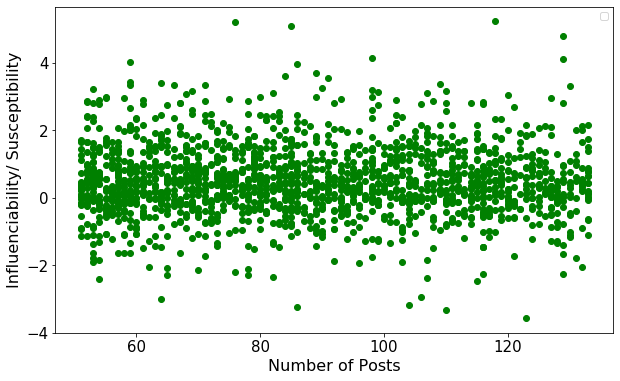

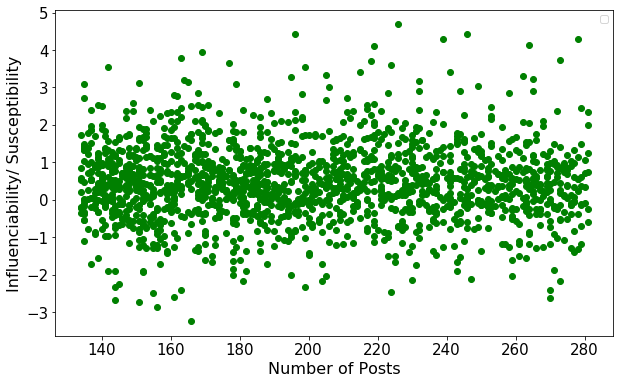

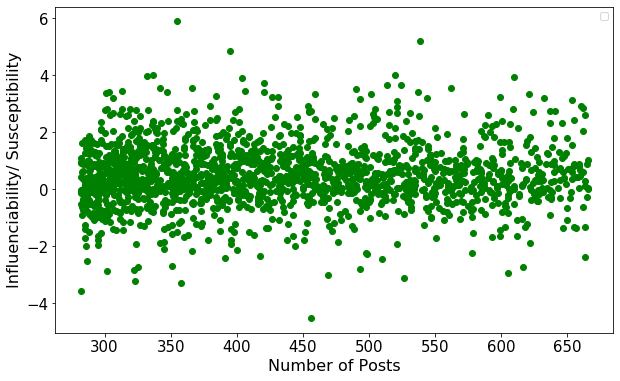

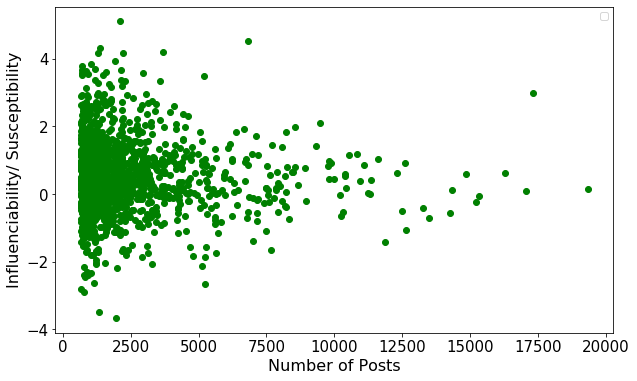

In [127]:
def plot_group_noPosts_and_alphas(median_fb, no_tweets, minPost, maxPost, label):
    alphas = []
    noPosts = []
    no_pos = 0
    no_neg = 0
    no_insg = 0
    
    for i in range(len(median_fb)):
        if no_tweets[i] > minPost and no_tweets[i] <= maxPost:
            alphas.append(median_fb[i])
            noPosts.append(no_tweets[i])
            
            if median_fb_pos[i] > 0: 
                no_pos +=1
            elif median_fb_neg[i] < 0:
                no_neg +=1
            else:
                no_insg +=1

    print('#pos #neg, #insign :', (no_pos, no_neg, no_insg))
    print('#pos #neg, #insign %:', (no_pos/len(noPosts), no_neg/len(noPosts), no_insg/len(noPosts)))
    
    fig = plt.figure()
    fig.set_size_inches(10, 6)
    plt.plot(noPosts, alphas, linestyle='None', marker='o', color='g')
    plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
    plt.xlabel('Number of Posts', fontsize = 16)
    plt.legend(loc='best')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.xticks(percentiles, percentile_est)
    plt.savefig(label+'.png', bbox_inches='tight')


no_posts_user = np.array(list(no_tweets.values()))

print(no_posts_user.shape)

per_scores = []
for perc in [0, 25, 50, 75, 100]:
    per_scores.append(np.percentile(no_posts_user, perc))
print(per_scores)
    
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[0], per_scores[1], label='twitter_group0_25_suscept')
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[1], per_scores[2], label='twitter_group25_50_suscept')
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[2], per_scores[3], label='twitter_group50_75_suscept')
plot_group_noPosts_and_alphas(median_fb, no_tweets, per_scores[3], per_scores[4], label='twitter_group75_100_suscept')



print('percentile 0%', np.percentile(no_posts_user, 0))
print('percentile 25%', np.percentile(no_posts_user, 25))
print('percentile 50%', np.percentile(no_posts_user, 50))
print('percentile 75%', np.percentile(no_posts_user, 75))
print('percentile 100%', np.percentile(no_posts_user, 100))



In [128]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(inter_arrival_times.keys()))
followers_cnt_pos = np.array([inter_arrival_times[u_id]for u_id in pos_fb_idx_]) * 24

neg_fb_idx_ = list(set(neg_fb_idx) & set(inter_arrival_times.keys()))
followers_cnt_neg = np.array([inter_arrival_times[u_id]for u_id in neg_fb_idx_]) *24

other_idx_ = list(set(other_idx) & set(inter_arrival_times.keys()))
followers_cnt_other = np.array([inter_arrival_times[u_id]for u_id in other_idx_]) *24

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])


print('pos ', np.median(followers_cnt_pos), 1.253*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.median(followers_cnt_neg), 1.253*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.median(followers_cnt_other), 1.253*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))

plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Inter-arrival time', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_inter_arrival_time.png', bbox_inches='tight')

NameError: name 'inter_arrival_times' is not defined

### Scattered plot between feedback estimate $\alpha_i$ and number of topics

No handles with labels found to put in legend.


spearmanr cor(fb_est, pos_fb) -0.048667578422982666
spearmanr cor(fb_est, neg_fb) -0.04596797132204713
spearmanr cor(fb_est, other) 0.0026111331602867317
pos  34.0 0.5766699630702121
neg  32.0 1.3001014755689182
insign  34.0 0.3010005189140655
pos  36.06871247498332 0.9020535735176503
neg  34.093525179856115 2.033678285806129
insign  36.2258005152742 0.4708388005359684


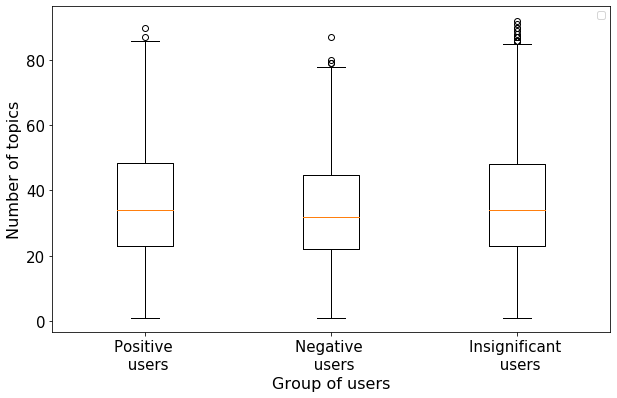

In [27]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(no_topics.keys()))
followers_cnt_pos = [no_topics[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(no_topics.keys()))
followers_cnt_neg = [no_topics[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(no_topics.keys()))
followers_cnt_other = [no_topics[u_id]for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])

print('pos ', np.median(followers_cnt_pos), 1.253*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.median(followers_cnt_neg), 1.253*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.median(followers_cnt_other), 1.253*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))

print('pos ', np.mean(followers_cnt_pos), 1.96*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.mean(followers_cnt_neg), 1.96*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.mean(followers_cnt_other), 1.96*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))

plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Number of topics', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_numberoftopics_time.png', bbox_inches='tight')

### Scattered plot between feedback estimate $\alpha_i$ and number of followers

In [28]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(no_followers.keys()) )
followers_cnt_pos = [no_followers[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(no_followers.keys()))
followers_cnt_neg = [no_followers[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(no_followers.keys()))
followers_cnt_other = [no_followers[u_id]for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])

print('pos ', np.mean(followers_cnt_pos), 1.96*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.mean(followers_cnt_neg), 1.96*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.mean(followers_cnt_other), 1.96*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))

plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Number of followers', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_nofollowers_time.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_followers_alpha_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_followers_alpha_neg.png', bbox_inches='tight')

NameError: name 'no_followers' is not defined

### Scattered plot between feedback estimate $\alpha_i$ and number of bidirectional followers

/home/davlan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


spearmanr cor(fb_est, pos_fb) nan
spearmanr cor(fb_est, neg_fb) nan
spearmanr cor(fb_est, other) nan
pos  nan nan
neg  nan nan
insign  nan nan


No handles with labels found to put in legend.
No handles with labels found to put in legend.


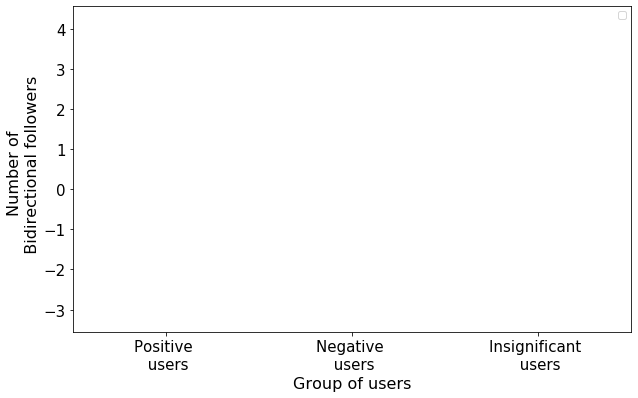

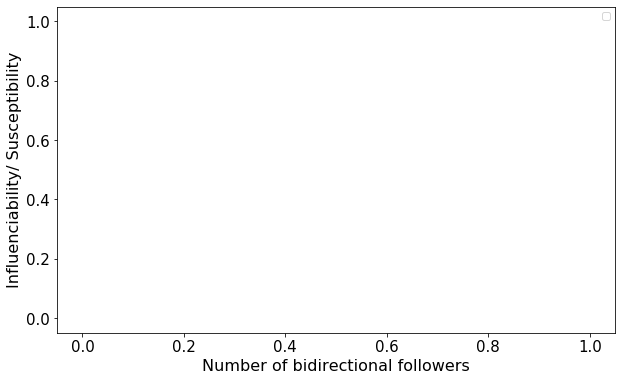

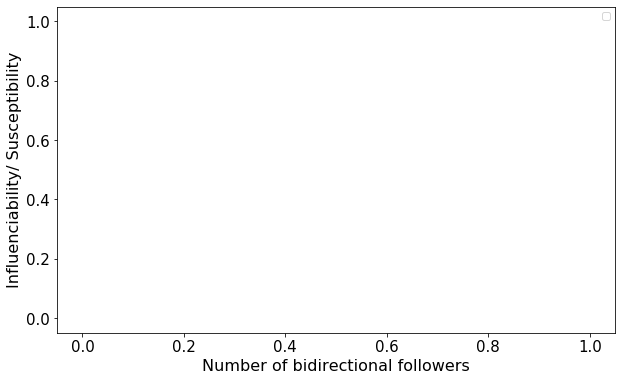

In [29]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(bidirectional_followers.keys()))
followers_cnt_pos = [bidirectional_followers[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(bidirectional_followers.keys()))
followers_cnt_neg = [bidirectional_followers[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(bidirectional_followers.keys()))
followers_cnt_other = [bidirectional_followers[u_id] for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])



#prob_b_f_pos = np.array(bfollowers_cnt_pos)/(np.array(followers_cnt_pos))
#prob_b_f_neg = np.array(bfollowers_cnt_neg)/(np.array(followers_cnt_neg))
#prob_b_f_other = np.array(bfollowers_cnt_other)/(np.array(followers_cnt_other))


print('pos ', np.mean(followers_cnt_pos), 1.96*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.mean(followers_cnt_neg), 1.96*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.mean(followers_cnt_other), 1.96*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))


plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Number of \n  Bidirectional followers', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_bidirectiona_time.png', bbox_inches='tight')

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of bidirectional followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_bidirFollower_alpha_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of bidirectional followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_bidirFollower_alpha_neg.png', bbox_inches='tight')

/home/davlan/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/davlan/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.


spearmanr cor(fb_est, pos_fb) nan
spearmanr cor(fb_est, neg_fb) nan
spearmanr cor(fb_est, other) nan
pos  nan nan
neg  nan nan
insign  nan nan


No handles with labels found to put in legend.
No handles with labels found to put in legend.


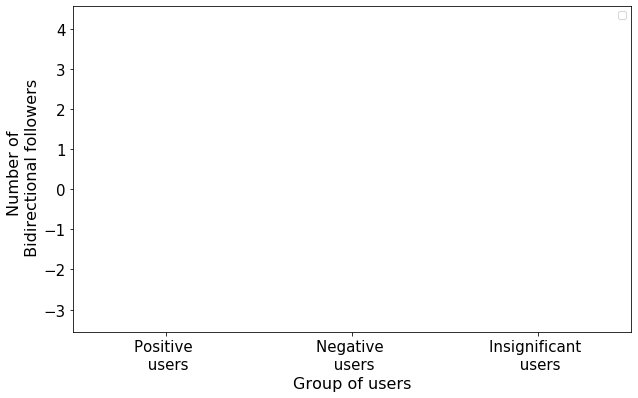

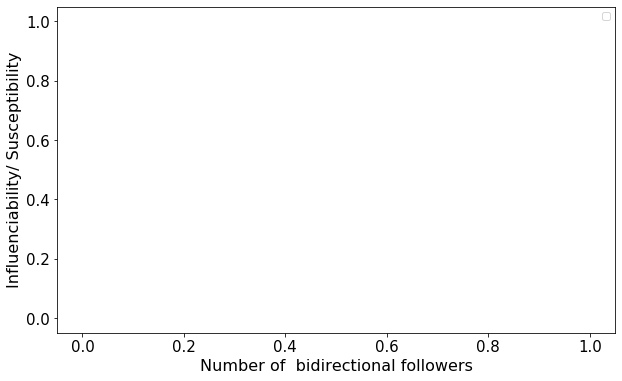

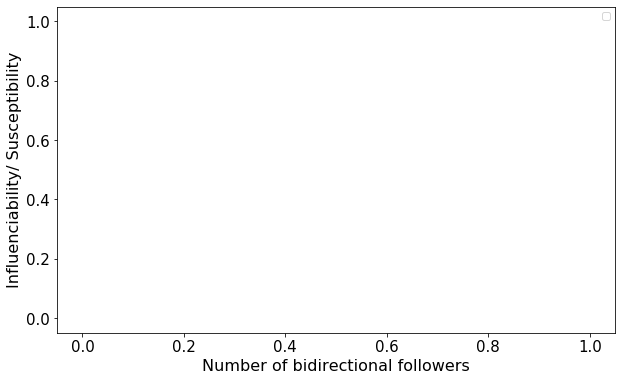

In [30]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(bidirectional_followers_100K.keys()))
followers_cnt_pos = [bidirectional_followers_100K[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(bidirectional_followers_100K.keys()))
followers_cnt_neg = [bidirectional_followers_100K[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(bidirectional_followers_100K.keys()))
followers_cnt_other = [bidirectional_followers_100K[u_id] for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])


print('pos ', np.median(followers_cnt_pos), 1.253*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.median(followers_cnt_neg), 1.253*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.median(followers_cnt_other), 1.253*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))

plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Number of \n Bidirectional followers', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_bidirectional100K.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of  bidirectional followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_bidirFollower_2K_alpha_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of bidirectional followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_bidirFollower_2K_alpha_neg.png', bbox_inches='tight')

### Scattered plot between feedback estimate $\alpha_i$ and age of account

In [31]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(age_of_user.keys()))
followers_cnt_pos = [age_of_user[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(age_of_user.keys()))
followers_cnt_neg = [age_of_user[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(age_of_user.keys()))
followers_cnt_other = [age_of_user[u_id]for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])


print('pos ', np.mean(followers_cnt_pos), 1.96*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.mean(followers_cnt_neg), 1.96*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.mean(followers_cnt_other), 1.96*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))


plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Age of account', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_ageofaccount.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_age_alpha_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of followers', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_age_alpha_neg.png', bbox_inches='tight')

NameError: name 'age_of_user' is not defined

### Scattered plot between feedback estimate $\alpha_i$ and number of tweets

No handles with labels found to put in legend.


spearmanr cor(fb_est, pos_fb) -0.06924476957020899
spearmanr cor(fb_est, neg_fb) 0.04213984579942274
spearmanr cor(fb_est, other) -0.010682693470394767
pos  694.8792528352235 61.75184637492992
neg  633.2841726618705 149.84666159894422
insign  725.6867868973133 37.421001278664164


"\nfig = plt.figure()\nfig.set_size_inches(10, 6)\nplt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')\nplt.ylabel('Influenciability/ Susceptibility', fontsize = 16)\nplt.xlabel('Number of Tweets', fontsize = 16)\nplt.legend(loc='best')\nplt.xticks(fontsize=15)\nplt.yticks(fontsize=15)\n#plt.xticks(percentiles, percentile_est)\nplt.savefig('twitter_cor_nTweets_alpha_pos.png', bbox_inches='tight')\n\n\nfig = plt.figure()\nfig.set_size_inches(10, 6)\nplt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')\nplt.ylabel('Influenciability/ Susceptibility', fontsize = 16)\nplt.xlabel('Number of Tweets', fontsize = 16)\nplt.legend(loc='best')\nplt.xticks(fontsize=15)\nplt.yticks(fontsize=15)\n#plt.xticks(percentiles, percentile_est)\nplt.savefig('twitter_cor_nTweets_alpha_neg.png', bbox_inches='tight')\n"

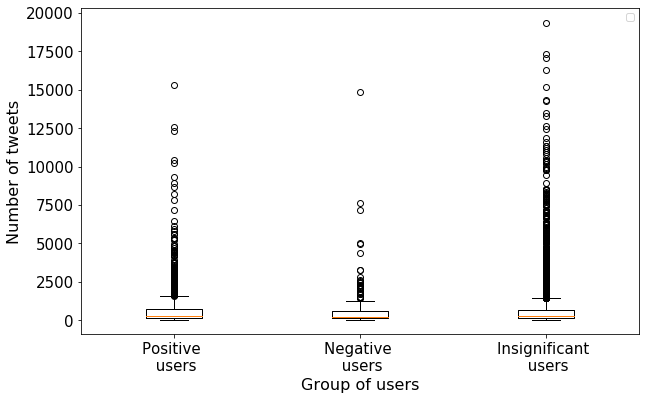

In [32]:
pos_fb_idx_ = list(set(pos_fb_idx) & set(no_tweets.keys()))
followers_cnt_pos = [no_tweets[u_id]for u_id in pos_fb_idx_]

neg_fb_idx_ = list(set(neg_fb_idx) & set(no_tweets.keys()))
followers_cnt_neg = [no_tweets[u_id]for u_id in neg_fb_idx_]

other_idx_ = list(set(other_idx) & set(no_tweets.keys()))
followers_cnt_other = [no_tweets[u_id]for u_id in other_idx_]

pos_fb = median_fb[pos_fb_idx_]
neg_fb = median_fb[neg_fb_idx_]
other_fb = median_fb[other_idx_]


print('spearmanr cor(fb_est, pos_fb)', spearmanr(pos_fb, followers_cnt_pos)[0])
print('spearmanr cor(fb_est, neg_fb)', spearmanr(neg_fb, followers_cnt_neg)[0])
print('spearmanr cor(fb_est, other)', spearmanr(other_fb, followers_cnt_other)[0])

print('pos ', np.mean(followers_cnt_pos), 1.96*np.std(followers_cnt_pos)/np.sqrt(len(followers_cnt_pos)))
print('neg ', np.mean(followers_cnt_neg), 1.96*np.std(followers_cnt_neg)/np.sqrt(len(followers_cnt_neg)))
print('insign ', np.mean(followers_cnt_other), 1.96*np.std(followers_cnt_other)/np.sqrt(len(followers_cnt_other)))



plot_data = [followers_cnt_pos, followers_cnt_neg, followers_cnt_other]

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.ylabel('Number of tweets', fontsize = 16)
plt.xlabel('Group of users', fontsize = 16)
plt.boxplot(plot_data)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(list(range(1,4)), ['Positive \n users', 'Negative \n users',  'Insignificant \n users'])
plt.savefig('twitter_numberoftweets.png', bbox_inches='tight')


'''
fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_pos, pos_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of Tweets', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_nTweets_alpha_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(followers_cnt_neg, neg_fb, linestyle='None', marker='o', color='g')
plt.ylabel('Influenciability/ Susceptibility', fontsize = 16)
plt.xlabel('Number of Tweets', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_nTweets_alpha_neg.png', bbox_inches='tight')
'''

### Scattered plot between feedback estimate $\alpha_i$ and user coefficient $a_i$

No handles with labels found to put in legend.


pearsonr cor(fb_est, user_est) 0.01767919696416818


No handles with labels found to put in legend.


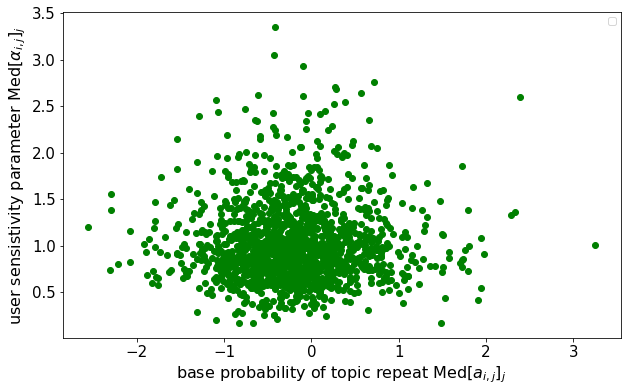

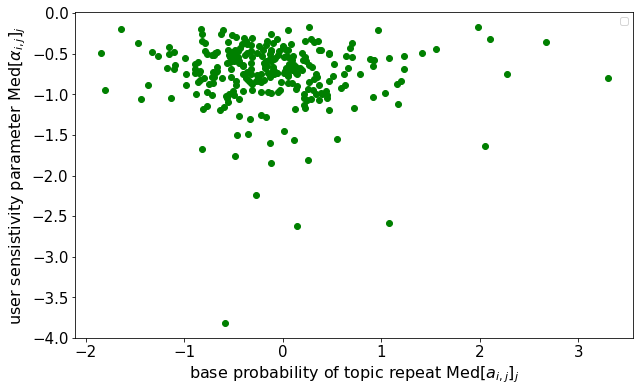

In [33]:
no_user = 7212
data = np.median(data_coef, axis=0) #np.loadtxt('model_parameters_model_user_event_fb_pumedian.txt')
fb_est = data[:no_user]
user_est = data[no_user+1:2*no_user+1]

fb_est_pos = fb_est[pos_fb_idx]
user_est_pos = user_est[pos_fb_idx]


fb_est_neg = fb_est[neg_fb_idx]
user_est_neg = user_est[neg_fb_idx]

print('pearsonr cor(fb_est, user_est)', spearmanr(fb_est_pos, user_est_pos)[0])


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(user_est_pos, fb_est_pos, linestyle='None', marker='o', color='g')
plt.ylabel('user sensistivity parameter 'r'${\rm Med}[\alpha_{i, j}]_j$', fontsize = 16)
plt.xlabel('base probability of topic repeat 'r'${\rm Med}[a_{i, j}]_j$', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_feedback_user_property_pos.png', bbox_inches='tight')


fig = plt.figure()
fig.set_size_inches(10, 6)
plt.plot(user_est_neg, fb_est_neg, linestyle='None', marker='o', color='g')
plt.ylabel('user sensistivity parameter 'r'${\rm Med}[\alpha_{i, j}]_j$', fontsize = 16)
plt.xlabel('base probability of topic repeat 'r'${\rm Med}[a_{i, j}]_j$', fontsize = 16)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xticks(percentiles, percentile_est)
plt.savefig('twitter_cor_feedback_user_property_neg.png', bbox_inches='tight')

## Model 1: controlling for user
\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{u=0} \gamma_u \delta_{u u_i} \right)
\label{eq:model_logit}
\end{equation}

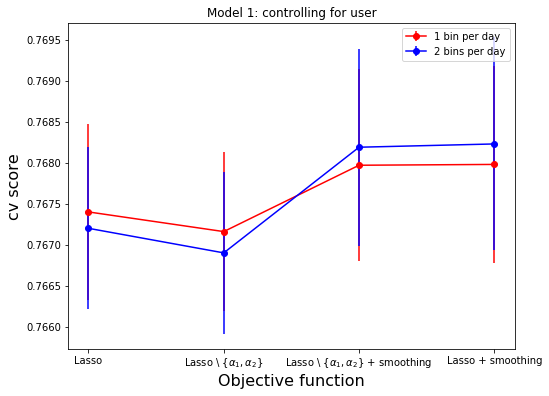

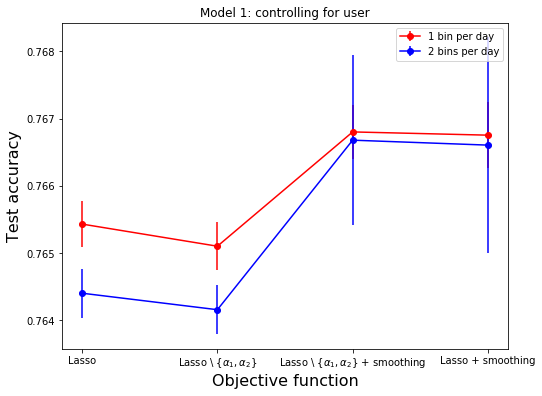

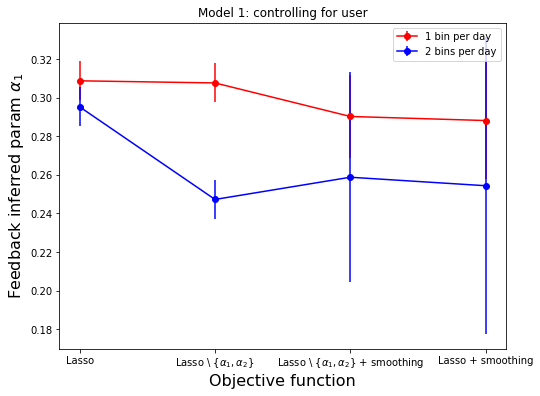

In [327]:
# Model 1 results
fb = np.zeros((2, 4))
fb_error = np.zeros((2, 4))
test_acc = np.zeros((2, 4))
test_acc_error = np.zeros((2, 4))
for b in range(2):
    res_acc = np.loadtxt('accuracy'+str(b+1)+'boot_u.txt').reshape(4, -1)
    test_acc[b] = res_acc[:,-2]
    test_acc_error[b] = res_acc[:,-1]
    for m in range(4):
        res_base = np.loadtxt('model_parameters_'+str(b+1)+'boot_u'+str(m)+'.txt').reshape(2, -1)
        fb[b,m] =res_base[0][0]
        fb_error[b,m] =res_base[1][0]
        
results_bin_obj = {'cv_score': np.array([[0.7674, 0.76716, 0.76797, 0.76798], [0.7672, 0.7669, 0.76819, 0.76823]]), 
                   'cv_std': np.array([[0.00107, 0.00097, 0.00117, 0.0012], [0.00099, 0.00099, 0.0012, 0.0013]]),
                   #'test_score': np.array([[0.7671, 0.76708, 0.76761, 0.7675], [0.76770, 0.76745, 0.7689, 0.7682]]),
                   'test_acc': test_acc,
                   'acc_error': test_acc_error,
                   'fb_param': np.array([[0.30544, 0.30392, 0.29094, 0.29978], [0.2930, 0.24522, 0.27941, 0.21855]]),
                   'fb_param': fb,
                   'fb_error': fb_error
                  }

user_idx = 7212
bins_per_day = np.array([1,2])
colors = ['r','b']
x = range(4)
xnames = ['Lasso', 'Lasso \ 'r'$\{\alpha_1, \alpha_2 \}$', 'Lasso \ 'r'$\{\alpha_1, \alpha_2\}$ + smoothing', 'Lasso + smoothing']
labelnames = ['1 bin per day', '2 bins per day']

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 1: controlling for user")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['cv_score'][binc], yerr = results_bin_obj['cv_std'][binc],linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('cv score', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_1_cv.png', bbox_inches='tight')

#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 1: controlling for user")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['test_acc'][binc], yerr = results_bin_obj['acc_error'][binc], linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('Test accuracy', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_1_testAcc.png', bbox_inches='tight')


#----------------Feedback inferred parameter
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 1: controlling for user")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['fb_param'][binc], yerr = results_bin_obj['fb_error'][binc], linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('Feedback inferred param 'r'$\alpha_1$', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_1_fb.png', bbox_inches='tight')

## Model 2: controlling for topic
\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{k=0} \phi_k \delta_{k k_i} \right)
\label{eq:model_logit}
\end{equation}

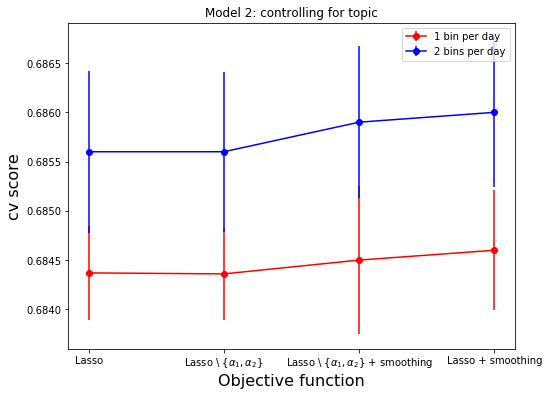

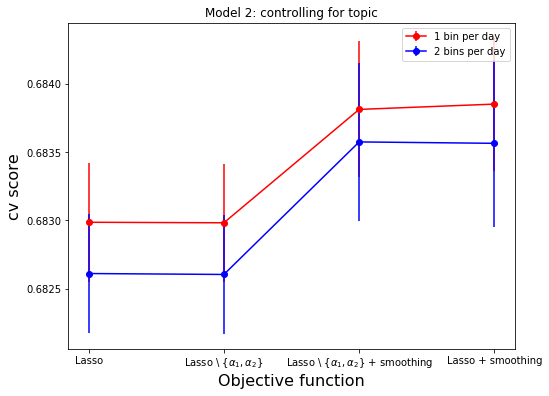

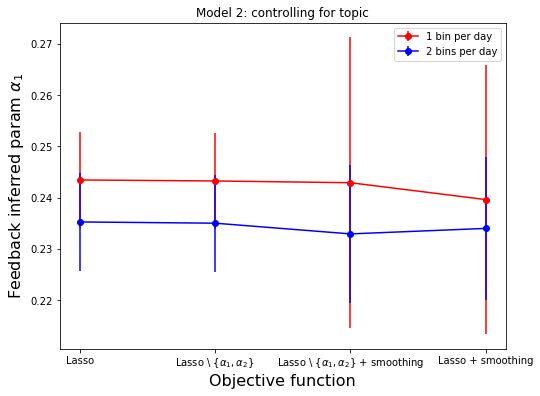

In [4]:
# Model 2 results
fb = np.zeros((2, 4))
fb_error = np.zeros((2, 4))
test_acc = np.zeros((2, 4))
test_acc_error = np.zeros((2, 4))
for b in range(2):
    res_acc = np.loadtxt('accuracy'+str(b+1)+'boot_t.txt').reshape(4, -1)
    test_acc[b] = res_acc[:,-2]
    test_acc_error[b] = res_acc[:,-1]
    for m in range(4):
        res_base = np.loadtxt('model_parameters_'+str(b+1)+'boot_t'+str(m)+'.txt').reshape(2, -1)
        fb[b,m] =res_base[0][0]
        fb_error[b,m] =res_base[1][0]
        
results_bin_obj = {'cv_score': np.array([[0.68437, 0.68436, 0.6845, 0.6846], [0.6856, 0.6856, 0.6859, 0.6860]]), 
                   'cv_std': np.array([[0.00048, 0.00047, 0.00075, 0.00061], [0.00082, 0.00081, 0.00077, 0.00076]]),
                   'test_score': np.array([[0.68457, 0.6845, 0.6846, 0.68468], [0.68542, 0.6854, 0.6857, 0.68576]]),
                   'test_acc': test_acc,
                   'acc_error': test_acc_error,
                   'fb_param': fb,
                   'fb_error': fb_error
                   #'fb_param': np.array([[0.23935, 0.239398, 0.2397, 0.2393], [0.2338, 0.23348, 0.2337, 0.2322]])
                  }



user_idx = 7212
bins_per_day = np.array([1,2])
colors = ['r','b']
x = range(4)
xnames = ['Lasso', 'Lasso \ 'r'$\{\alpha_1, \alpha_2 \}$', 'Lasso \ 'r'$\{\alpha_1, \alpha_2\}$ + smoothing', 'Lasso + smoothing']
labelnames = ['1 bin per day', '2 bins per day']

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 2: controlling for topic")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['cv_score'][binc], yerr = results_bin_obj['cv_std'][binc],linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('cv score', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_2_cv.png', bbox_inches='tight')

#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 2: controlling for topic")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['test_acc'][binc], results_bin_obj['acc_error'][binc], linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('cv score', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_2_testAcc.png', bbox_inches='tight')


#----------------Feedback inferred parameter
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 2: controlling for topic")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['fb_param'][binc], results_bin_obj['fb_error'][binc], linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('Feedback inferred param 'r'$\alpha_1$', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_2_fb.png', bbox_inches='tight')

## Model 3: controlling for user and topic
\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{u=0} \gamma_u \delta_{u u_i} + \sum_{k=0} \phi_k \delta_{k k_i} \right)
\label{eq:model_logit}
\end{equation}

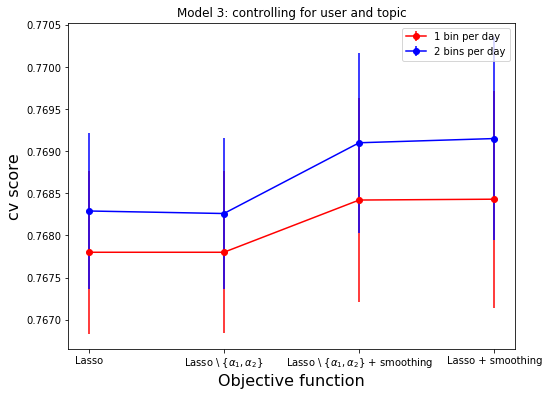

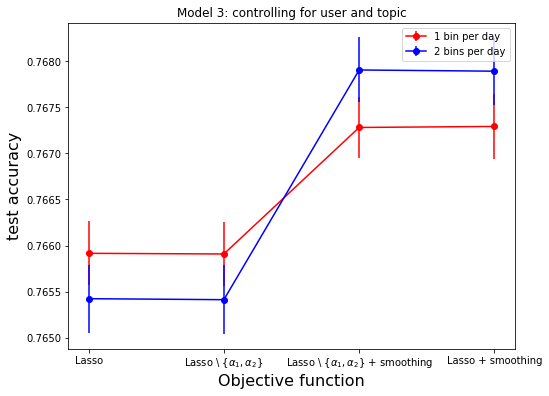

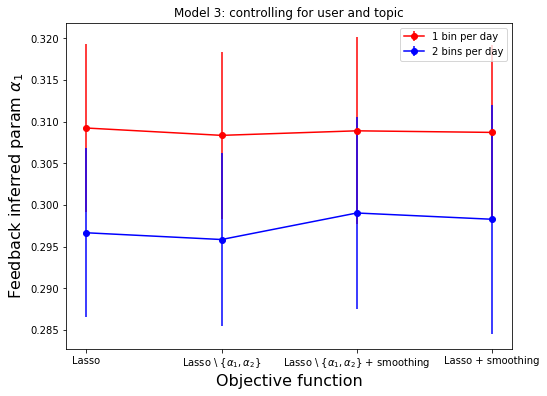

In [5]:
# Model 3 results
fb = np.zeros((2, 4))
fb_error = np.zeros((2, 4))
test_acc = np.zeros((2, 4))
test_acc_error = np.zeros((2, 4))
for b in range(2):
    res_acc = np.loadtxt('accuracy'+str(b+1)+'boot_ut.txt').reshape(4, -1)
    test_acc[b] = res_acc[:,-2]
    test_acc_error[b] = res_acc[:,-1]
    for m in range(4):
        res_base = np.loadtxt('model_parameters_'+str(b+1)+'boot_ut'+str(m)+'.txt').reshape(2, -1)
        fb[b,m] =res_base[0][0]
        fb_error[b,m] =res_base[1][0]
        
results_bin_obj = {'cv_score': np.array([[0.7678, 0.7678, 0.76842, 0.76843], [0.76829, 0.76826, 0.7691, 0.76915]]), 
                   'cv_std': np.array([[0.00097, 0.00096, 0.00121, 0.00129], [0.00093, 0.0009, 0.00107, 0.0012]]),
                   'test_score': np.array([[0.76786, 0.76785, 0.7684, 0.76837], [0.7692, 0.7691, 0.76975, 0.76977]]),
                   #'fb_param': np.array([[0.3103, 0.3079, 0.3087, 0.31164], [0.29175, 0.2898, 0.2950, 0.2983]]),
                   'test_acc': test_acc,
                   'acc_error': test_acc_error,
                   'fb_param': fb,
                   'fb_error': fb_error,
                  }

user_idx = 7212
bins_per_day = np.array([1,2])
colors = ['r','b']
x = range(4)
xnames = ['Lasso', 'Lasso \ 'r'$\{\alpha_1, \alpha_2 \}$', 'Lasso \ 'r'$\{\alpha_1, \alpha_2\}$ + smoothing', 'Lasso + smoothing']
labelnames = ['1 bin per day', '2 bins per day']

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 3: controlling for user and topic")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['cv_score'][binc], yerr = results_bin_obj['cv_std'][binc],linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('cv score', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_3_cv.png', bbox_inches='tight')


#----------------Test accuracy
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 3: controlling for user and topic")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['test_acc'][binc], yerr = results_bin_obj['acc_error'][binc], linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('test accuracy', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_3_testAcc.png', bbox_inches='tight')


#----------------Feedback inferred parameter
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title("Model 3: controlling for user and topic")

for binc in range(len(bins_per_day)):
    plt.errorbar(x, results_bin_obj['fb_param'][binc], yerr = results_bin_obj['fb_error'][binc], linestyle='-', marker='o', color=colors[binc],  label = labelnames[binc])
        
plt.ylabel('Feedback inferred param 'r'$\alpha_1$', fontsize = 16)
plt.xlabel('Objective function', fontsize = 16)
plt.xticks(x, xnames)
plt.legend(loc='best')
plt.savefig('model_3_fb.png', bbox_inches='tight')

[0.30888649633761778, 0.29902620112887418, 0.29533557349244688, 0.29422807610070623, 0.29323630470592948]


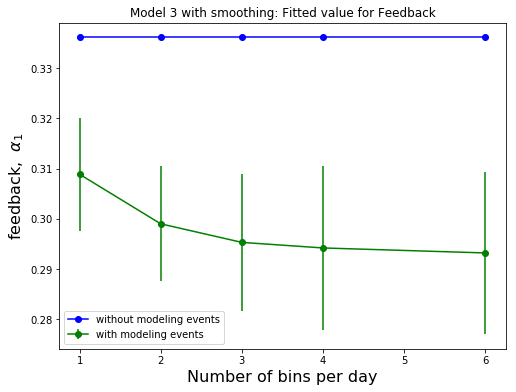

In [6]:
# Proposed Objective function: beta_1 value
import matplotlib.pyplot as plt
import numpy as np
'model_parameters_'+str(b+1)+'boot_ut'+str(m)+'.txt'
bins_per_day = [1,2,3,4,6]

res_base = np.loadtxt('model_parameters_bsplit.txt')

betas_1 = []
std_errors = []
baseline = 0.3360939# res_base[0] 
for binc in bins_per_day:
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_ut2.txt')
    res = data[0][0]
    betas_1.append(res)
    error = data[1][0]
    std_errors.append(error)

print(betas_1)
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Model 3 with smoothing: Fitted value for Feedback')

plt.errorbar(bins_per_day, betas_1, yerr = std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('chosen_model_fb.png', bbox_inches='tight')

1
2
3
4
6


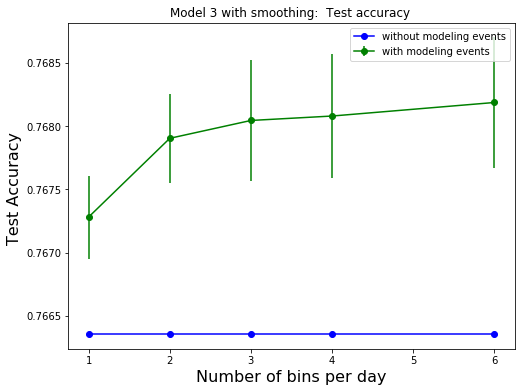

In [7]:
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6] 
accuracies = []
std_errors = []
for binc in bins_per_day:
    print(binc)
    data = np.loadtxt('accuracy'+str(binc)+'boot_ut.txt')
    res = data[-2]
    error = data[-1]
    if binc < 3: 
        res = data[2][-2]
        error = data[2][-1]
        
    accuracies.append(res)
    std_errors.append(error)
    

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Model 3 with smoothing:  Test accuracy ')

plt.errorbar(bins_per_day, accuracies, yerr=std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [0.76635575]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Test Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('chosen_model_accuracy.png', bbox_inches='tight')

/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


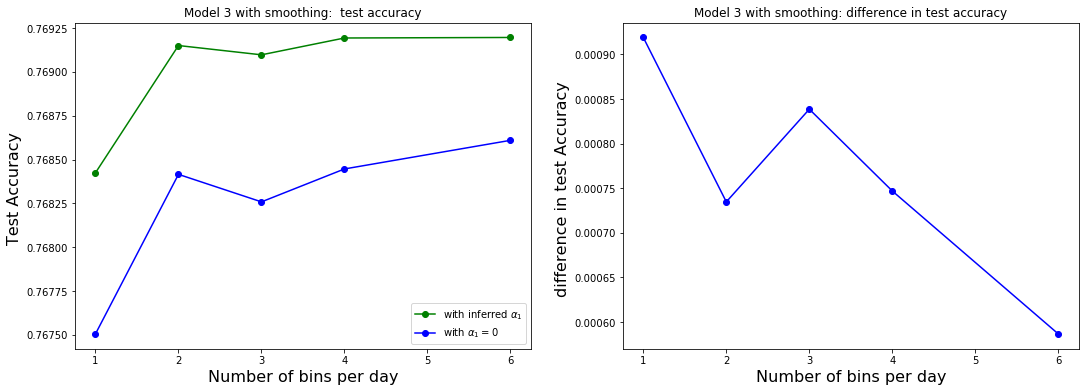

In [8]:
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6] 
accur_withalpha = np.array([0.768424, 0.76915, 0.769097, 0.769193, 0.769196])
diff_accuracies = np.array([0.000919, 0.0007347, 0.0008386, 0.00074687, 0.0005866])


fig = plt.figure()
fig.set_size_inches(18, 6)
plt.subplot(1, 2, 1)
plt.title('Model 3 with smoothing:  test accuracy')
plt.plot(bins_per_day, accur_withalpha ,  marker='o', color='g', label='with inferred 'r'$\alpha_1$')
plt.plot(bins_per_day, accur_withalpha-diff_accuracies ,  marker='o', color='b', label='with 'r'$\alpha_1=0$')
#plt.plot(bins_per_day, [0.76635575]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Test Accuracy ', fontsize = 16)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Model 3 with smoothing: difference in test accuracy')
plt.plot(bins_per_day, diff_accuracies ,  marker='o', color='b')
#plt.plot(bins_per_day, [0.76635575]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('difference in test Accuracy ', fontsize = 16)
plt.legend(loc='best')

plt.savefig('chosen_model_diff_accuracy.png', bbox_inches='tight')

Non-zero features:  25540
25612
6 [[ 12  13  14]
 [ 13  14  15]
 [ 14  15  16]
 [ 15  16  17]
 [ 16  17  18]
 [ 17  18  19]
 [ 18  19  20]
 [ 19  20  21]
 [ 20  21  22]
 [ 21  22  23]
 [ 22  23  24]
 [ 23  24  25]
 [ 24  25  26]
 [ 25  26  27]
 [ 26  27  28]
 [ 27  28  29]
 [ 28  29  30]
 [ 29  30  31]
 [106 107 108]
 [153 154 155]
 [180 181 182]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


14 [[12 13 14]
 [13 14 15]
 [35 36 37]
 [36 37 38]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


17 [[27 28 29]
 [28 29 30]
 [57 58 59]
 [58 59 60]
 [59 60 61]
 [60 61 62]
 [61 62 63]
 [62 63 64]
 [63 64 65]
 [70 71 72]
 [71 72 73]
 [72 73 74]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


19 [[ 1  2  3]
 [ 2  3  4]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]
 [15 16 17]
 [16 17 18]
 [17 18 19]
 [18 19 20]
 [19 20 21]
 [20 21 22]
 [21 22 23]
 [22 23 24]
 [23 24 25]
 [24 25 26]
 [25 26 27]
 [26 27 28]
 [27 28 29]
 [28 29 30]
 [29 30 31]
 [30 31 32]
 [31 32 33]
 [32 33 34]
 [33 34 35]
 [34 35 36]
 [35 36 37]
 [36 37 38]
 [37 38 39]
 [38 39 40]
 [39 40 41]
 [63 64 65]
 [64 65 66]
 [65 66 67]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


20 [[ 60  61  62]
 [ 61  62  63]
 [ 62  63  64]
 [ 63  64  65]
 [ 64  65  66]
 [ 65  66  67]
 [ 66  67  68]
 [ 67  68  69]
 [ 68  69  70]
 [ 69  70  71]
 [ 70  71  72]
 [ 75  76  77]
 [173 174 175]
 [174 175 176]
 [175 176 177]
 [176 177 178]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


25 [[ 23  24  25]
 [ 52  53  54]
 [ 53  54  55]
 [ 89  90  91]
 [ 90  91  92]
 [ 91  92  93]
 [ 92  93  94]
 [ 93  94  95]
 [121 122 123]
 [122 123 124]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


36 [[ 30  31  32]
 [ 31  32  33]
 [ 32  33  34]
 [ 33  34  35]
 [ 34  35  36]
 [ 49  50  51]
 [103 104 105]
 [104 105 106]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


43 [[ 50  51  52]
 [ 51  52  53]
 [ 78  79  80]
 [ 79  80  81]
 [125 126 127]
 [157 158 159]
 [158 159 160]
 [159 160 161]
 [171 172 173]
 [172 173 174]
 [178 179 180]
 [179 180 181]
 [180 181 182]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


56 [[ 44  45  46]
 [ 45  46  47]
 [121 122 123]
 [122 123 124]
 [142 143 144]
 [163 164 165]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


60 [[ 94  95  96]
 [ 95  96  97]
 [ 96  97  98]
 [ 97  98  99]
 [ 98  99 100]
 [ 99 100 101]
 [169 170 171]
 [170 171 172]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


# topics with 3 consecutive positive betas  10


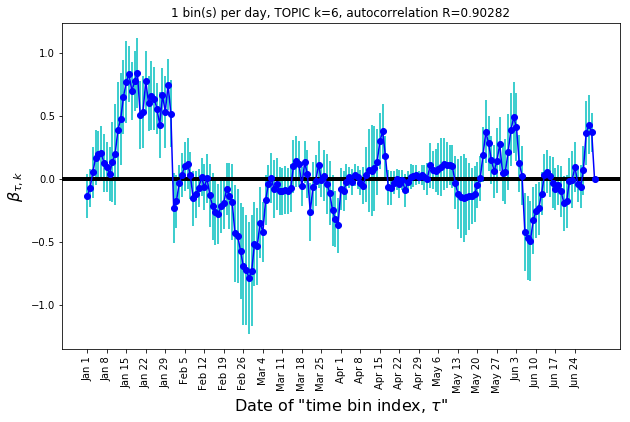

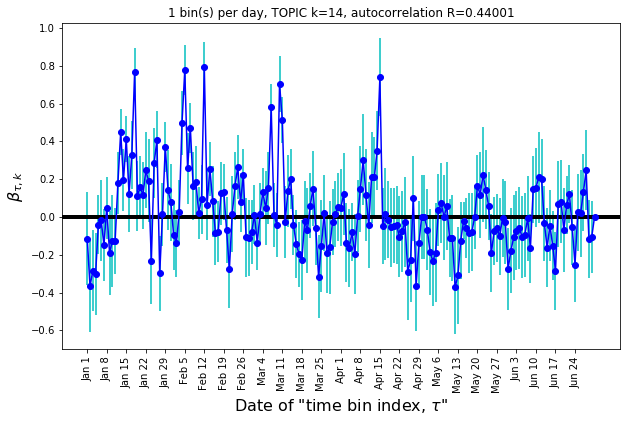

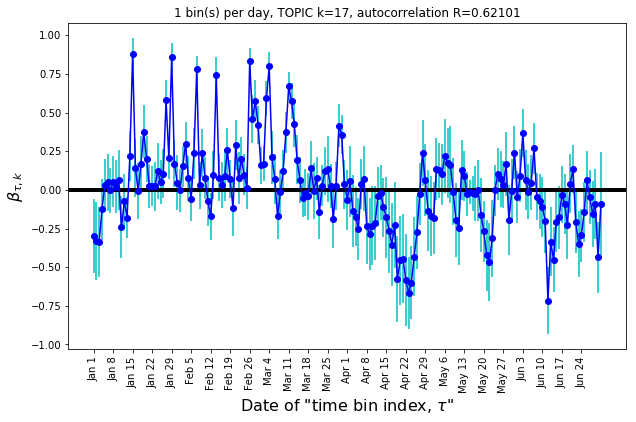

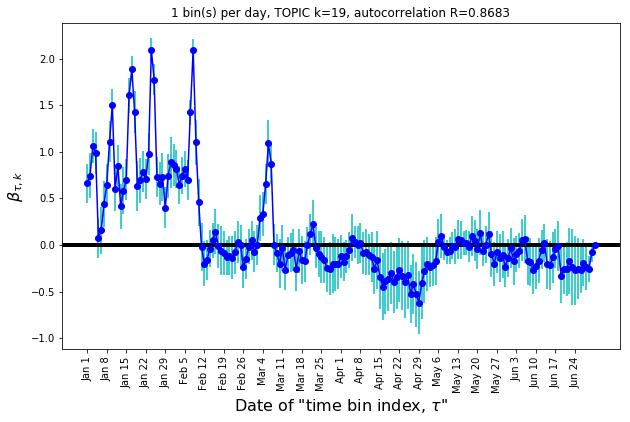

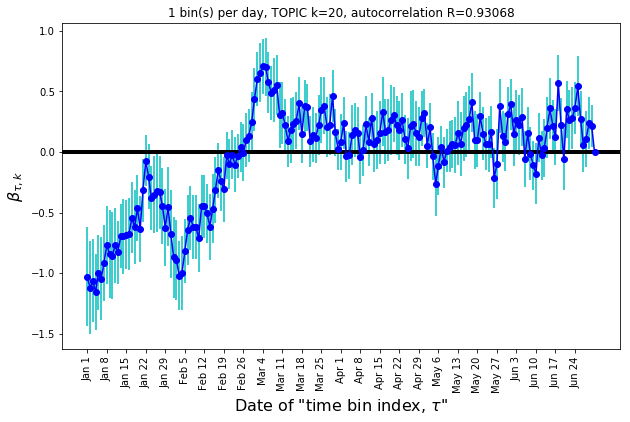

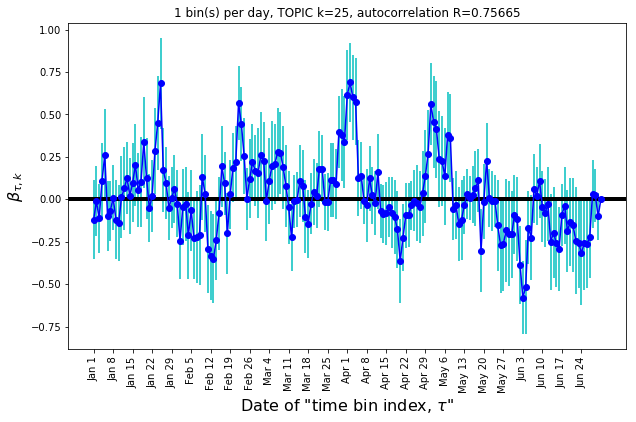

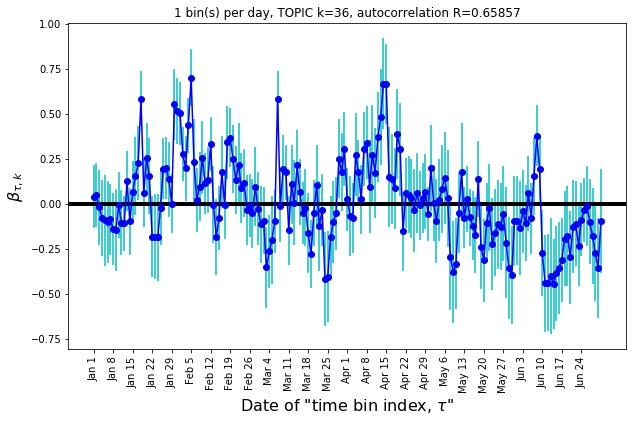

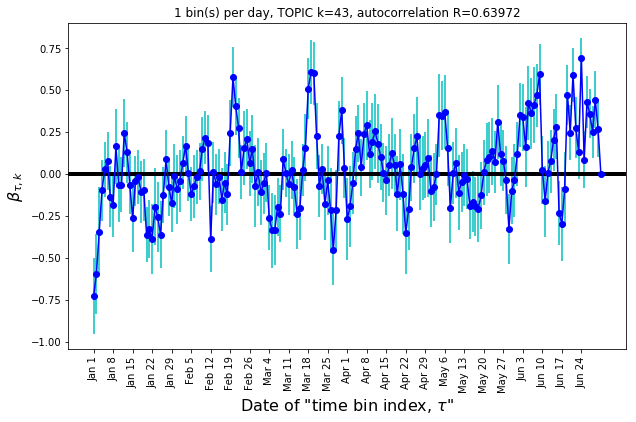

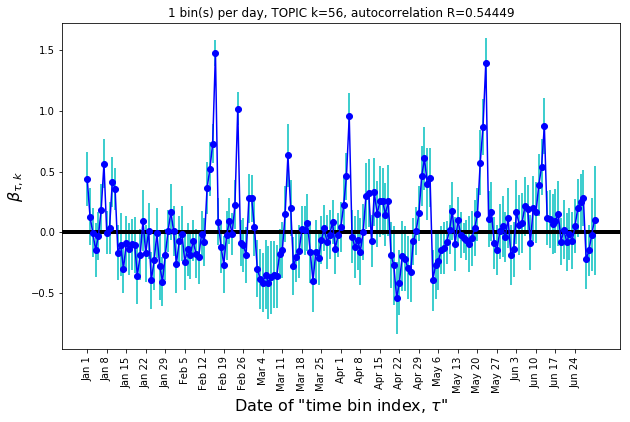

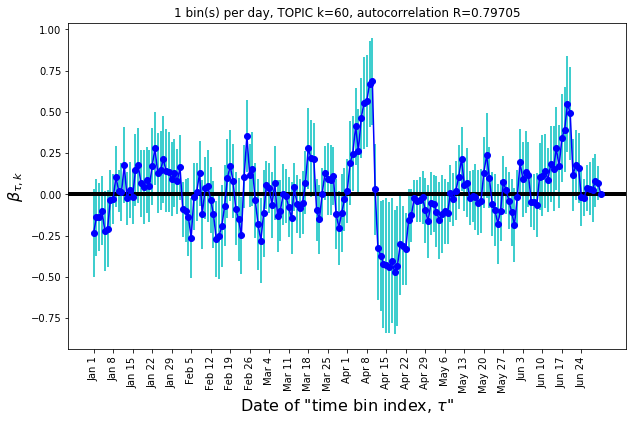

In [9]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)



user_idx = 7212
j=0

data = np.loadtxt('model_parameters_'+str(1)+'boot_ut2.txt')
res = data[0]
res_error = data[1]
binc=1
print('Non-zero features: ', len(np.where(res!=0)[0]))
N = len(res)
print(N)

no_topics = 100
topic_time_evt_matrix = res[100+7212:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[100+7212:].flatten().reshape(no_topics, -1)

jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = [6, 14, 17, 19, 20, 25, 36, 43, 56, 60]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    plt.title(title_name+ ', autocorrelation R='+str(round(autocorr,5)))
    plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

    plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('beta_topic'+str(top)+'.png', bbox_inches='tight')

print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    


Non-zero features:  32743
32821
average alpha  0.156483436574


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


6 [[ 12  13  14]
 [ 13  14  15]
 [ 14  15  16]
 [ 15  16  17]
 [ 16  17  18]
 [ 17  18  19]
 [ 18  19  20]
 [ 19  20  21]
 [ 20  21  22]
 [ 21  22  23]
 [ 22  23  24]
 [ 23  24  25]
 [ 24  25  26]
 [ 25  26  27]
 [ 26  27  28]
 [ 27  28  29]
 [ 28  29  30]
 [ 29  30  31]
 [153 154 155]
 [180 181 182]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


14 [[12 13 14]
 [13 14 15]
 [35 36 37]
 [36 37 38]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


17 [[27 28 29]
 [28 29 30]
 [57 58 59]
 [58 59 60]
 [59 60 61]
 [60 61 62]
 [61 62 63]
 [62 63 64]
 [63 64 65]
 [70 71 72]
 [71 72 73]
 [72 73 74]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


19 [[ 1  2  3]
 [ 2  3  4]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]
 [13 14 15]
 [14 15 16]
 [15 16 17]
 [16 17 18]
 [17 18 19]
 [18 19 20]
 [19 20 21]
 [20 21 22]
 [21 22 23]
 [22 23 24]
 [23 24 25]
 [24 25 26]
 [25 26 27]
 [26 27 28]
 [27 28 29]
 [28 29 30]
 [29 30 31]
 [30 31 32]
 [31 32 33]
 [32 33 34]
 [33 34 35]
 [34 35 36]
 [35 36 37]
 [36 37 38]
 [37 38 39]
 [38 39 40]
 [39 40 41]
 [63 64 65]
 [64 65 66]
 [65 66 67]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


20 [[ 60  61  62]
 [ 61  62  63]
 [ 62  63  64]
 [ 63  64  65]
 [ 64  65  66]
 [ 65  66  67]
 [ 66  67  68]
 [ 67  68  69]
 [ 68  69  70]
 [ 69  70  71]
 [ 75  76  77]
 [176 177 178]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


25 [[ 23  24  25]
 [ 53  54  55]
 [ 89  90  91]
 [ 90  91  92]
 [ 91  92  93]
 [ 92  93  94]
 [ 93  94  95]
 [121 122 123]
 [122 123 124]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


36 [[ 30  31  32]
 [ 31  32  33]
 [ 32  33  34]
 [ 33  34  35]
 [ 34  35  36]
 [ 49  50  51]
 [103 104 105]
 [104 105 106]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


43 [[ 50  51  52]
 [ 51  52  53]
 [ 78  79  80]
 [ 79  80  81]
 [125 126 127]
 [157 158 159]
 [158 159 160]
 [159 160 161]
 [171 172 173]
 [172 173 174]
 [178 179 180]
 [179 180 181]
 [180 181 182]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


56 [[ 44  45  46]
 [ 45  46  47]
 [121 122 123]
 [122 123 124]
 [142 143 144]
 [163 164 165]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


60 [[ 94  95  96]
 [ 95  96  97]
 [ 96  97  98]
 [ 97  98  99]
 [ 98  99 100]
 [ 99 100 101]
 [169 170 171]
 [170 171 172]]


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


# topics with 3 consecutive positive betas  10


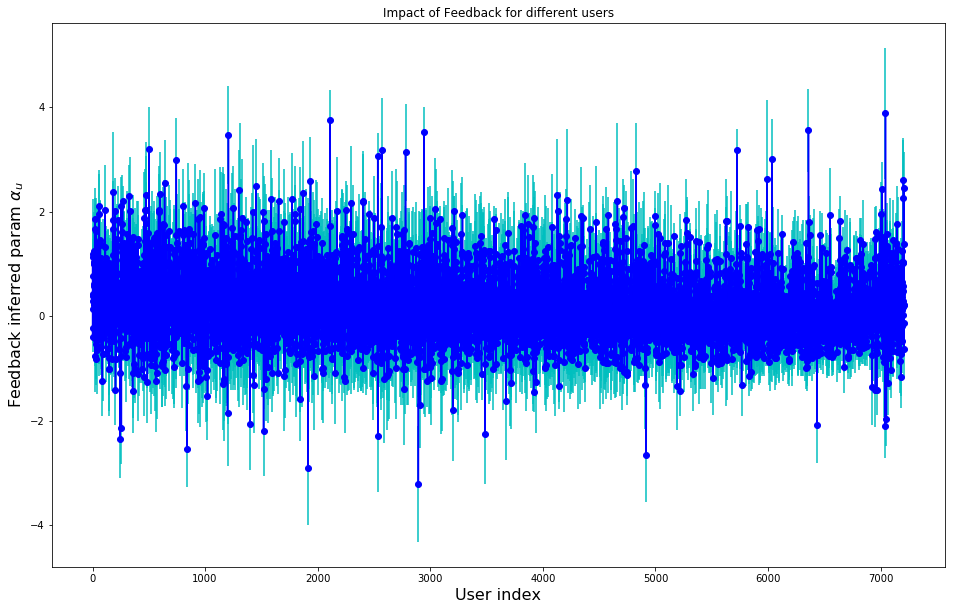

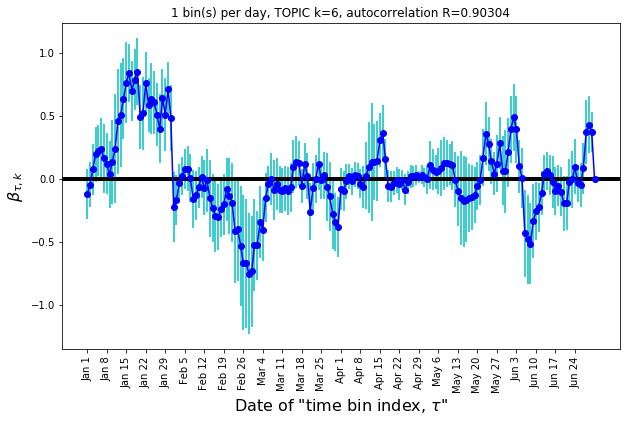

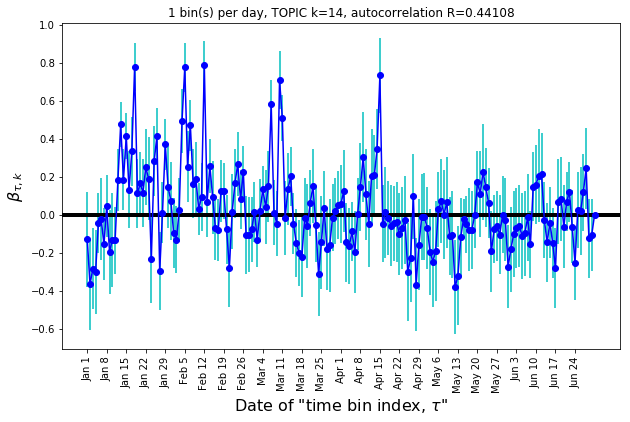

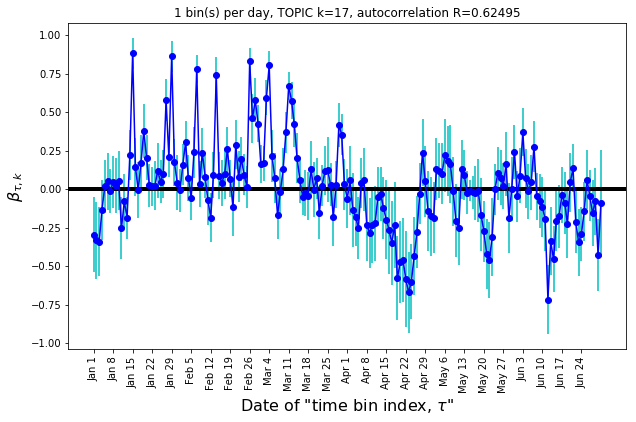

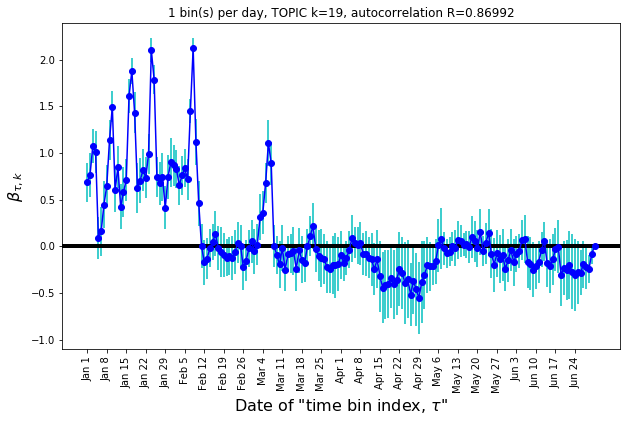

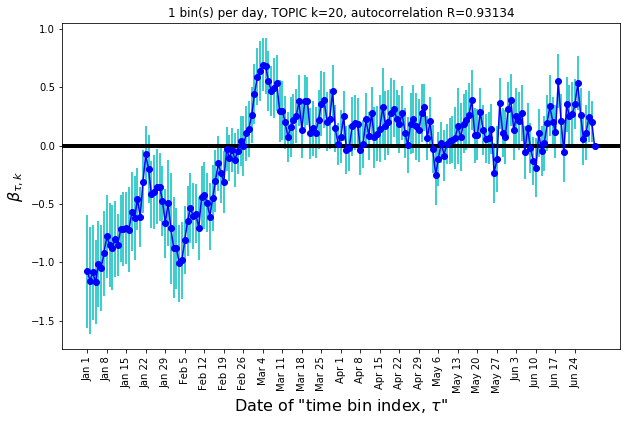

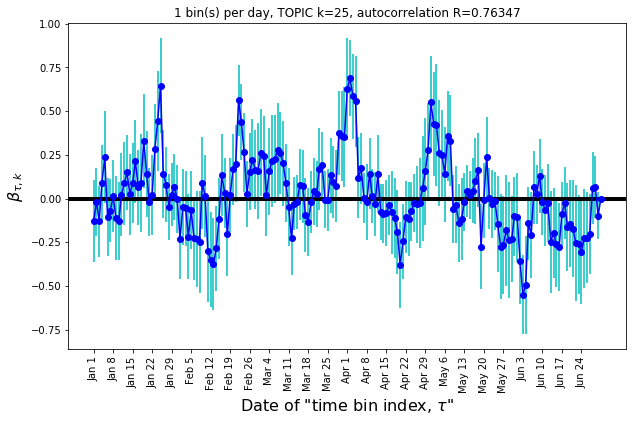

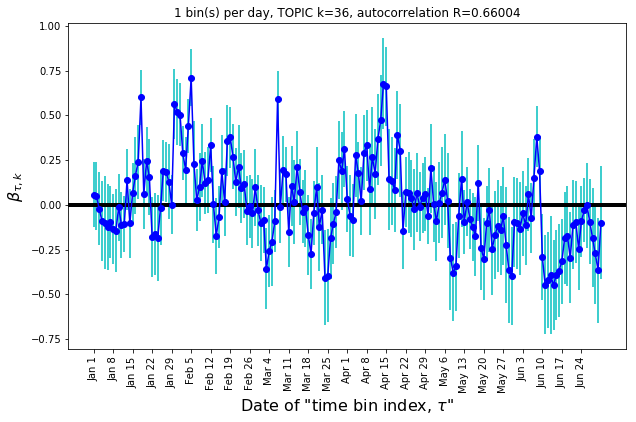

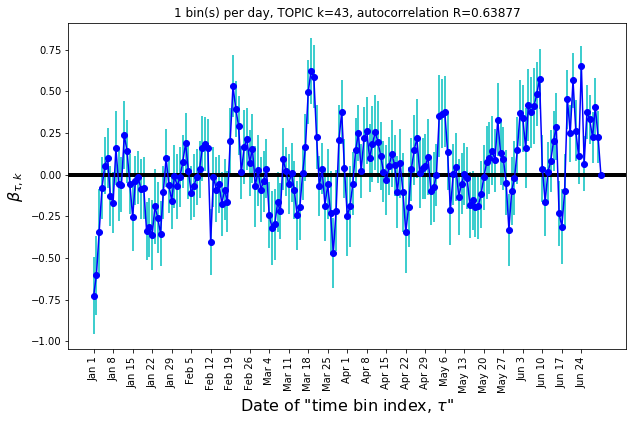

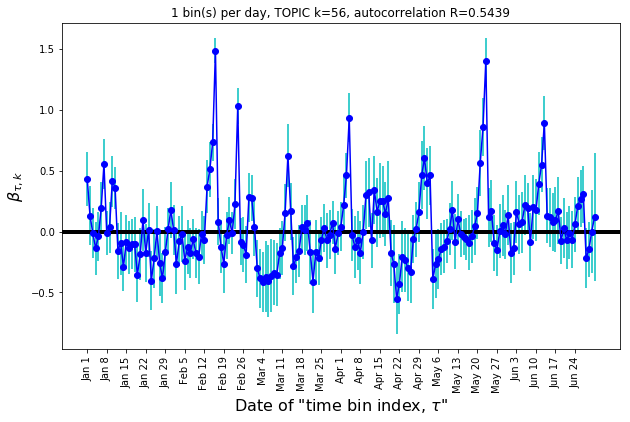

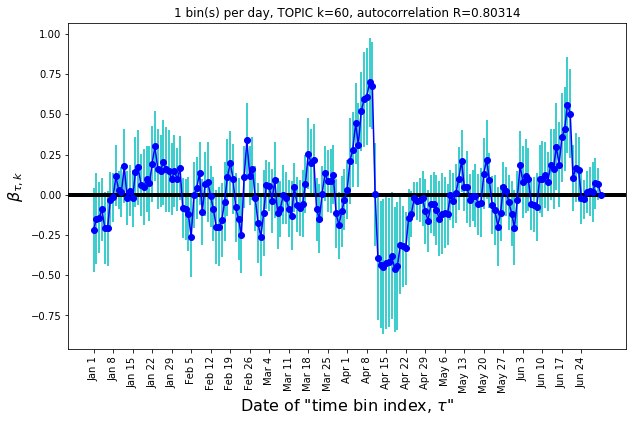

In [13]:
def consecutive_number_bigger_than_x(my_list, no_seq=3, x=0):
    result = [my_list[i:i+no_seq] for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    result_idx = [list(range(i,i+no_seq)) for i in range(len(my_list)-(no_seq-1)) if all(i > x for i in my_list[i:i+no_seq])]
    return result, result_idx
# Logistic regression with the proposed objective (bootstrap)



user_idx = 7212
j=0

data = np.loadtxt('model_parameters_perUser1boot_ut2.txt')
res = data[0]
res_error = data[1]
binc=1
print('Non-zero features: ', len(np.where(res!=0)[0]))
N = len(res)
print(N)


alphas_u = res[:7210]
alphas_u_err = res_error[:7210]
print('average alpha ', np.mean(alphas_u))

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.title("Impact of Feedback for different users")

plt.errorbar(range(7210), alphas_u, yerr = alphas_u_err, linestyle='-', marker='o', color='b',  ecolor='c')
        
plt.ylabel('Feedback inferred param 'r'$\alpha_u$', fontsize = 16)
plt.xlabel('User index', fontsize = 16)
plt.legend(loc='best')
plt.savefig('feedback_different_users.png', bbox_inches='tight')



no_topics = 100
topic_time_evt_matrix = res[7210+1+100+7210:].flatten().reshape(no_topics, -1)
topic_time_evt_matrix_std = res_error[7210+1+100+7210:].flatten().reshape(no_topics, -1)

jan = ['Jan '+str(i+1) for i in range(31)]
feb = ['Feb '+str(i+1) for i in range(29)]
mar = ['Mar '+str(i+1) for i in range(31)]
apr = ['Apr '+str(i+1) for i in range(30)]
may = ['May '+str(i+1) for i in range(31)]
jun = ['Jun '+str(i+1) for i in range(30)]

time_bins = np.array(jan+feb+mar+apr+may+jun)
x_bins = [k for k in range(182) if k%7==0]

imp_topics = [6, 14, 17, 19, 20, 25, 36, 43, 56, 60]  # selected by comparing beta value with topic definition
topic_NoconsEvents = {}
no_topics_with_consEvts = 0
for top in imp_topics:
    
    res = topic_time_evt_matrix[top]
    N = len(res)
    error = topic_time_evt_matrix_std[top]

    res_min_error = res - error
    res_min_error[res_min_error<0] = 0
    
    result, result_idx = consecutive_number_bigger_than_x(res_min_error, no_seq=3, x=0)
    topic_NoconsEvents[top] = len(result)
    
    
    if len(result) > 0:
        no_topics_with_consEvts+=1
        print(top, np.array(result_idx)+1)
        j+=1
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top)
        
    

    autocorr = pearsonr(res[:-1], res[1:])[0]
    #print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

    minr = np.min(res)
    maxr = np.max(res)
    fig = plt.figure()
    fig.subplots_adjust(hspace=.50)
    fig.set_size_inches(10, 6)
    plt.subplot(1, 1, 1)
    plt.title(title_name+ ', autocorrelation R='+str(round(autocorr,5)))
    plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
    plt.xlabel('Date of "time bin index, 'r'$\tau$"', fontsize = 16)

    plt.errorbar(list(range(N)), res, yerr=error ,linestyle='-', marker='o', color='b', ecolor='c')
    #plt.stem(list(range(N)), [0]*N, linestyle='-', marker='o', color='r')
    plt.axhline(linewidth=4, color='k')
    #plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
    #plt.plot([2,2], [minr-2, maxr+2], color='k')
    #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.xticks(x_bins, time_bins[x_bins])
    plt.xticks(rotation=90)
    plt.locator_params(axis='x', nbins=27)
    plt.legend(loc='best')
    plt.savefig('beta_topic'+str(top)+'.png', bbox_inches='tight')

print('# topics with 3 consecutive positive betas ', no_topics_with_consEvts)
#print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
#print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    


In [ ]:
# Logistic regression with the lasso (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6] 
accuracies = []
std_errors = []
for binc in bins_per_day:
    print(binc)
    data = np.loadtxt('accuracy'+str(binc)+'boot_ut.txt')
    res = data[-2]
    error = data[-1]
    if binc < 3: 
        res = data[2][-2]
        error = data[2][-1]
        
    accuracies.append(res)
    std_errors.append(error)
    

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Model 3 with smoothing:  Accuracy ')

plt.errorbar(bins_per_day, accuracies, yerr=std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
#plt.plot(bins_per_day, [0.755318]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Training Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('chosen_model_accuracy.png', bbox_inches='tight')

exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_ut0.txt')
    res = data[0]
    res_error = data[1]
    
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[100+7212:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[100+7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            #avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.amax(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model3_beta_lasso_user_topic.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  25540
25612
183
haha
correlation (binc, topic, autocorrelation): (1, 93, 0.606686) 
183
haha
correlation (binc, topic, autocorrelation): (1, 95, 0.454056) 
Non-zero features:  43429
43512
362
correlation (binc, topic, autocorrelation): (2, 93, 0.689259) 
362
correlation (binc, topic, autocorrelation): (2, 95, 0.608582) 
Non-zero features:  43429
43512
362
haha
correlation (binc, topic, autocorrelation): (2, 93, 0.592230) 
362
haha
correlation (binc, topic, autocorrelation): (2, 95, 0.450693) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.990574717919544
correlation between 1bin_perday, 2bins_perday, topic 2  0.9833369973892171


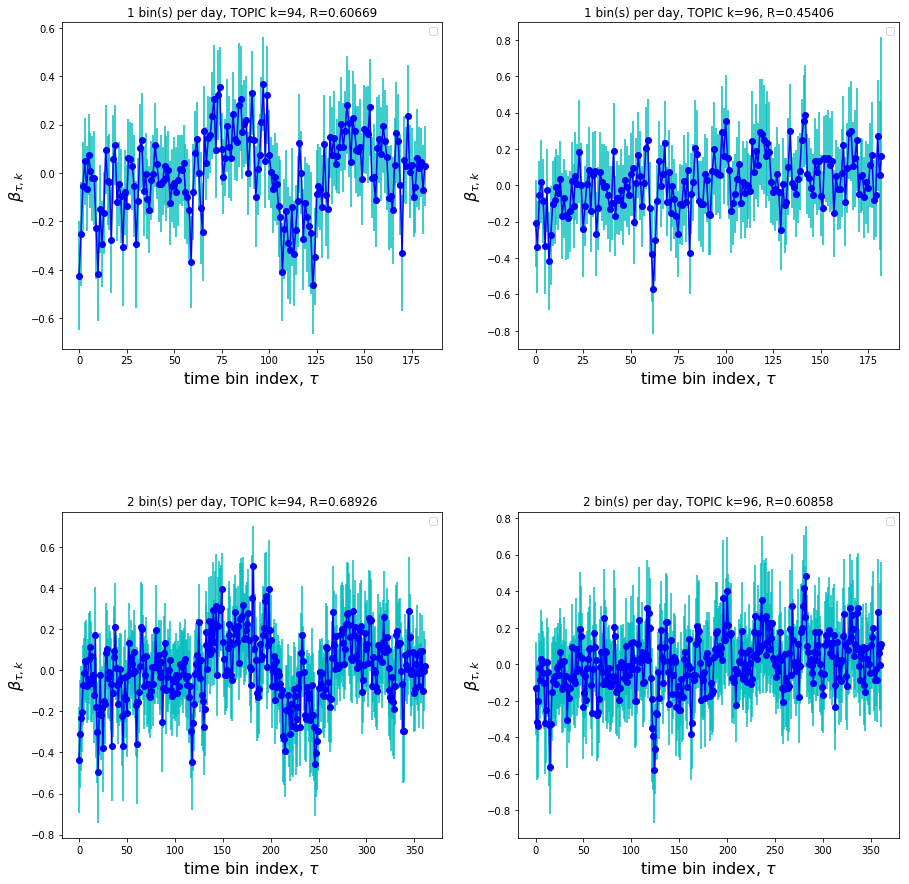

In [9]:
# Logistic regression with the proposed objective (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_ut2.txt')
    res = data[0]
    res_error = data[1]
    
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[100+7212:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[100+7212:].flatten().reshape(no_topics, -1)
    
    imp_topics = [14,17, 19, 21, 25, 30, 31, 32, 36, 37, 50, 51, 57, 58, 59, 60, 64, 65,75,76,78,79,86,87,93, 95]
    for top in [93,95]:
        j+=1
        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.amax(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model3_beta_smooth_user_topic.png', bbox_inches='tight')

Non-zero features:  25456
25512
183
haha
correlation (binc, topic, autocorrelation): (1, 0, 0.791621) 
183
haha
correlation (binc, topic, autocorrelation): (1, 1, 0.871901) 
Non-zero features:  43356
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.852630) 


/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/admin/.local/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


362
correlation (binc, topic, autocorrelation): (2, 1, 0.865397) 
Non-zero features:  43356
43412
362
haha
correlation (binc, topic, autocorrelation): (2, 0, 0.786888) 
362
haha
correlation (binc, topic, autocorrelation): (2, 1, 0.770167) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.908197477051
correlation between 1bin_perday, 2bins_perday, topic 2  0.921171125837


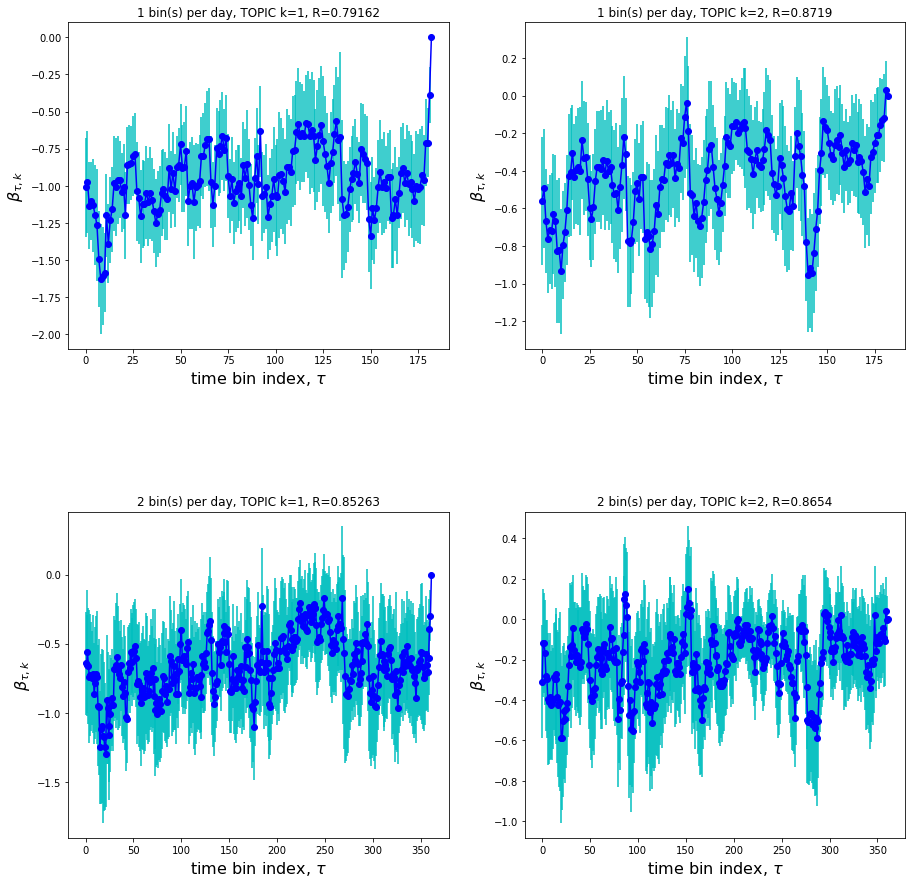

In [9]:
# Logistic regression with the proposed objective (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot_u2.txt')
    res = data[0]
    res_error = data[1]
    
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    topic_time_evt_matrix_std = res_error[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.amax(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model3_beta_smooth_user.png', bbox_inches='tight')

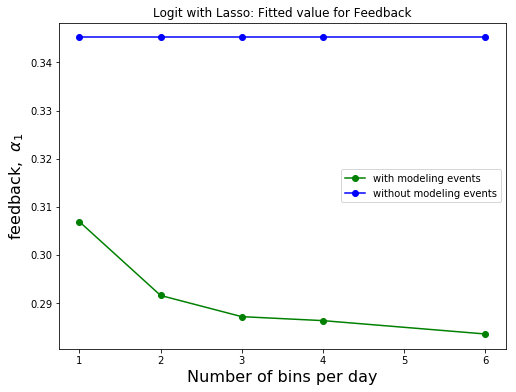

In [7]:
# Logistic regression with Lasso: beta_1 value
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

res_base = np.loadtxt('model_parameters_b.txt')

betas_1 = []
baseline =  res_base[0]               
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    betas_1.append(res[0])

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Logit with Lasso: Fitted value for Feedback')

plt.plot(bins_per_day, betas_1, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_M1.png', bbox_inches='tight')

In [8]:
# compute standard error
def get_standardError(data, alpha=0.05):
    stat_rt_data = np.sort(data, axis=0)
    num_samples = len(data)
    low_conf_rt_data = stat_rt_data[int((alpha / 2.0) * num_samples)]
    high_conf_rt_data = stat_rt_data[int((1 - alpha / 2.0) * num_samples)]
    rt_data_error = (high_conf_rt_data - low_conf_rt_data) / 2.0

    return rt_data_error

No handles with labels found to put in legend.


Non-zero features:  25459


No handles with labels found to put in legend.


Non-zero features:  43357


No handles with labels found to put in legend.


Non-zero features:  61457


No handles with labels found to put in legend.


Non-zero features:  79361


No handles with labels found to put in legend.


Non-zero features:  114112


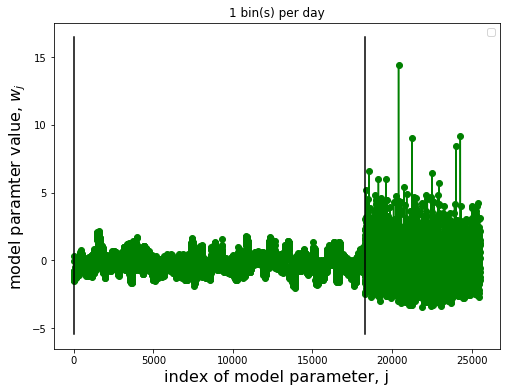

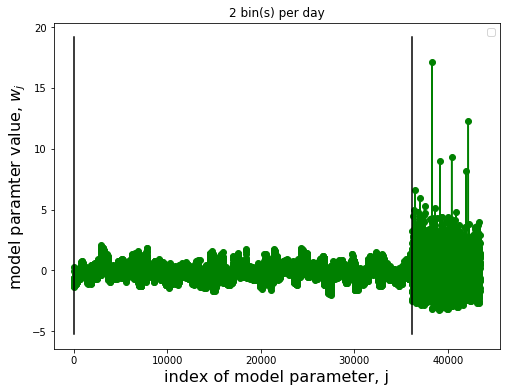

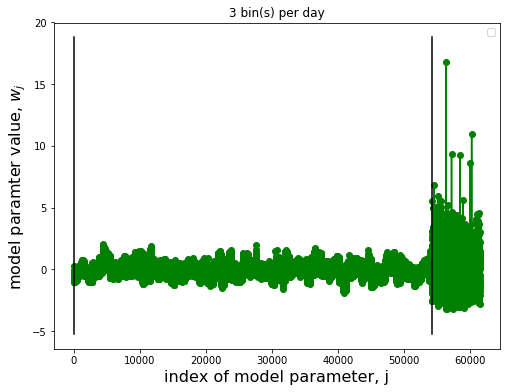

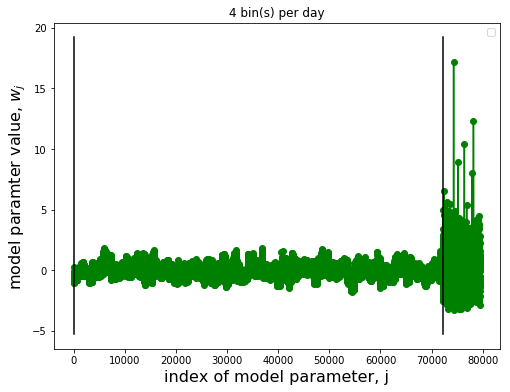

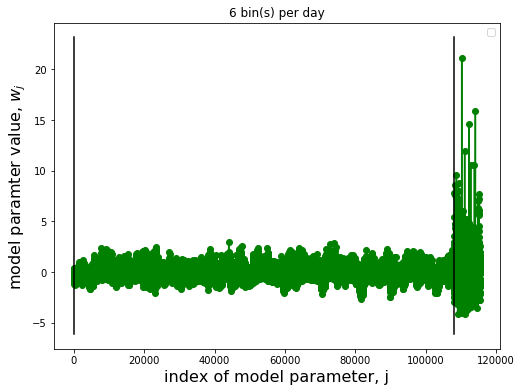

In [9]:
# Proposed Objective function
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

user_idx = 7212
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'s.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    resA = res[user_idx:]
    resB = res[2:user_idx]
    res = np.concatenate((res[:2], resA, resB))
    N = len(res)
    
    minr = np.min(res)
    maxr = np.max(res)
    
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.title(str(binc)+' bin(s) per day')

    plt.plot(res, linestyle='-', marker='o', color='g')
    plt.plot([2,2], [minr-2, maxr+2], color='k')
    plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.ylabel('model paramter value, ' r'$w_j$', fontsize = 16)
    plt.xlabel('index of model parameter, 'r'j', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('model_betas_'+str(binc)+'mbins_per_day.png', bbox_inches='tight')

[0.2994493005408749, 0.2727115826532283, 0.2637505333516687, 0.2335682844992853, 0.2747031787447318, 0.2720133867019029, 0.26974067785164524]


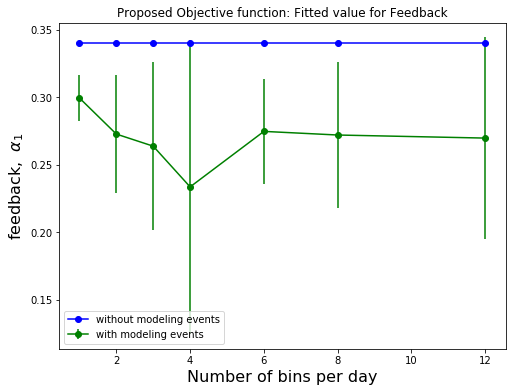

In [10]:
# Proposed Objective function: beta_1 value
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6, 8, 12]

res_base = np.loadtxt('model_parameters_bsplit.txt')

betas_1 = []
std_errors = []
baseline =  res_base[0]               
for binc in bins_per_day:
    data = np.loadtxt('model_parameters_'+str(binc)+'boot.txt')
    res = np.mean(data[:,0])
    betas_1.append(res)
    error = get_standardError(data[:,0]) 
    std_errors.append(error)

print(betas_1)
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function: Fitted value for Feedback')

plt.errorbar(bins_per_day, betas_1, yerr = std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_M2.png', bbox_inches='tight')

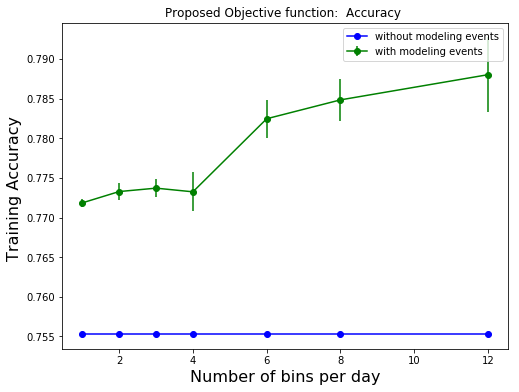

In [10]:
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6, 8, 12] 
#accuracies = [0.771432, 0.773625, 0.775621, 0.776912, 0.778454]
#accuracies = [0.77091, 0.77174, 0.77187, 0.771558, 0.77588]
#accuracies = [0.771234, 0.77357, 0.7750, 0.7752, 0.7764]
accuracies = []
std_errors = []
baseline =  res_base[0]               
for binc in bins_per_day:
    data = np.loadtxt('accuracy'+str(binc)+'boot.txt')
    res = np.mean(data)
    accuracies.append(res)
    error = 1.96*np.std(data)#get_standardError(data[:,0]) 
    std_errors.append(error)
    

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function:  Accuracy ')

plt.errorbar(bins_per_day, accuracies, yerr=std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [0.755318]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Training Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_accuracy.png', bbox_inches='tight')

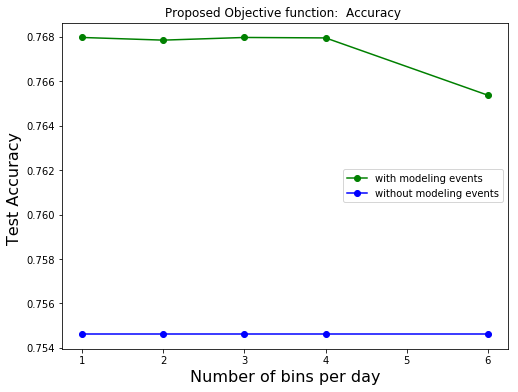

In [12]:
# Accuracy metric for the proposed method
bins_per_day = [1,2,3,4,6] 
#accuracies = [0.76834, 0.76824, 0.76707, 0.76641, 0.76592]
accuracies = [0.76797, 0.76785, 0.76797, 0.76795, 0.76537]

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function:  Accuracy ')

plt.plot(bins_per_day, accuracies, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [0.7546257]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('Test Accuracy ', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_test_accuracy.png', bbox_inches='tight')

No handles with labels found to put in legend.


Non-zero features:  25147


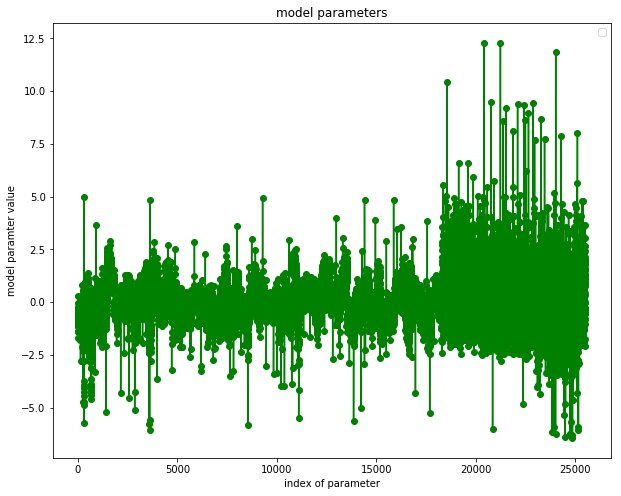

In [13]:
res = np.loadtxt('model_parameters_1bcv.txt')
print('Non-zero features: ', len(np.where(res!=0)[0]))
fig = plt.figure()
fig.set_size_inches(10, 8)
plt.title('model parameters')

plt.plot(res, linestyle='-', marker='o', color='g')
plt.ylabel('model paramter value')
plt.xlabel('index of parameter')
plt.legend(loc='best')
plt.savefig('model_beta.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  23827
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.642477) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.840268) 
Non-zero features:  38317
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.538989) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.383350) 
Non-zero features:  38317
43412
183
correlation (binc, topic, autocorrelation): (2, 0, 0.741665) 
183
correlation (binc, topic, autocorrelation): (2, 1, 0.576540) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.3679695805059211
correlation between 1bin_perday, 2bins_perday, topic 2  -0.022302287869793158


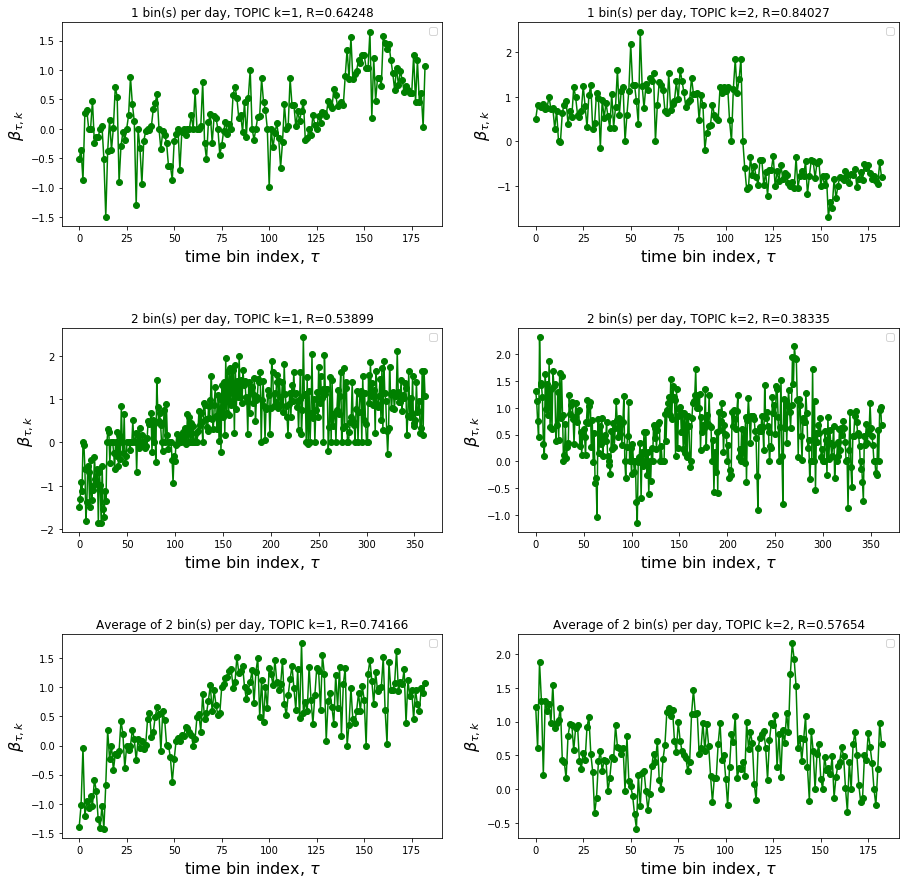

In [14]:
# Logistic regression with Lasso


with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0
per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            #print(res)
            res = np.mean(res, axis=1)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            per_bin_results.append(res)
        
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(3, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    

'''
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))
        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(2, 2, j)
        plt.title(str(binc)+' bin(s) per day, TOPIC k='+str(top+1)+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
'''    
    
plt.savefig('model_betas_perTopic_lasso.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  23827
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.642477) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.840268) 
Non-zero features:  38317
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.538989) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.383350) 
Non-zero features:  38317
43412
183
correlation (binc, topic, autocorrelation): (2, 0, 0.741665) 
183
correlation (binc, topic, autocorrelation): (2, 1, 0.576540) 


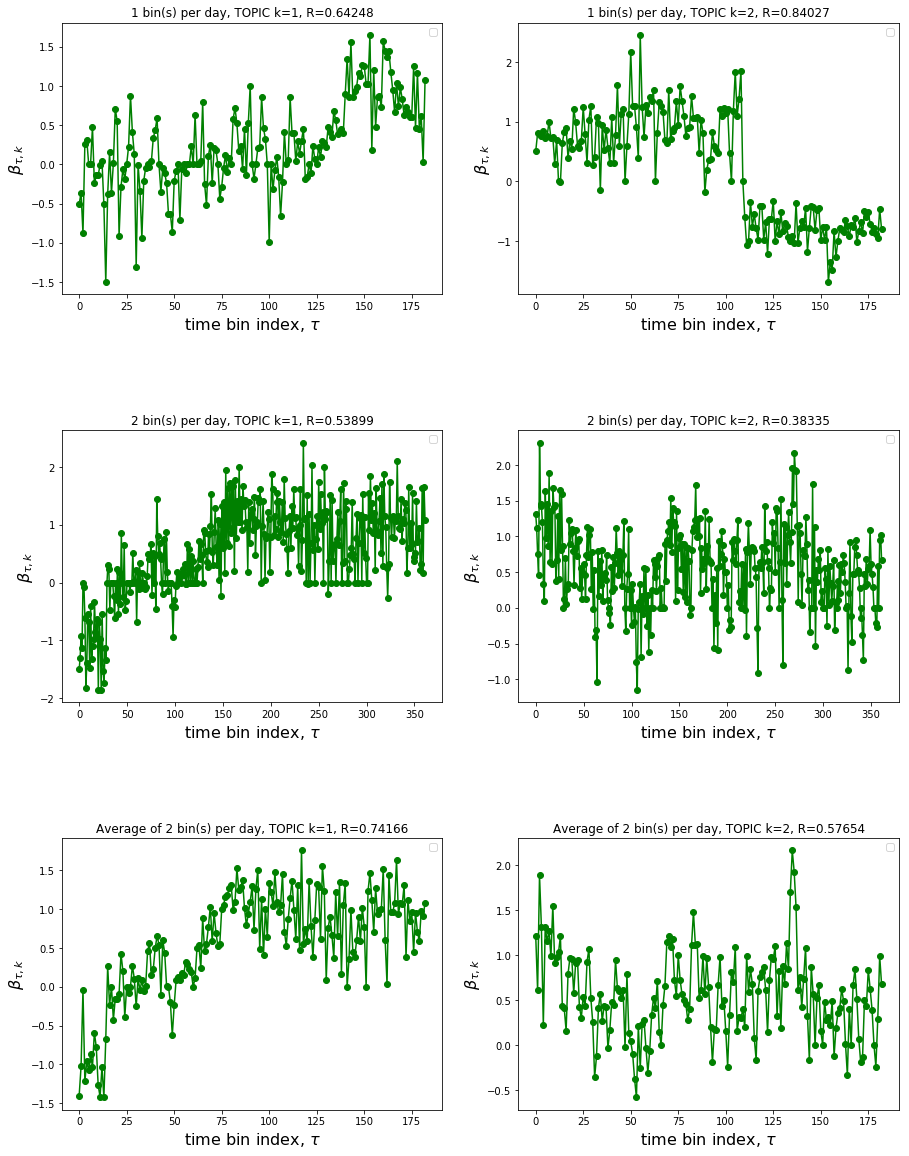

In [15]:
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 20)

user_idx = 7212
j=0
for i, binc in enumerate(bins_per_day):
    
    res = np.loadtxt('model_parameters_'+str(binc)+'.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            #print(res)
            res = np.mean(res, axis=1)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(3, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
    
plt.savefig('model_betas_perTopic_lasso.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  25459
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.803493) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.878579) 
Non-zero features:  43357
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.890711) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.891088) 


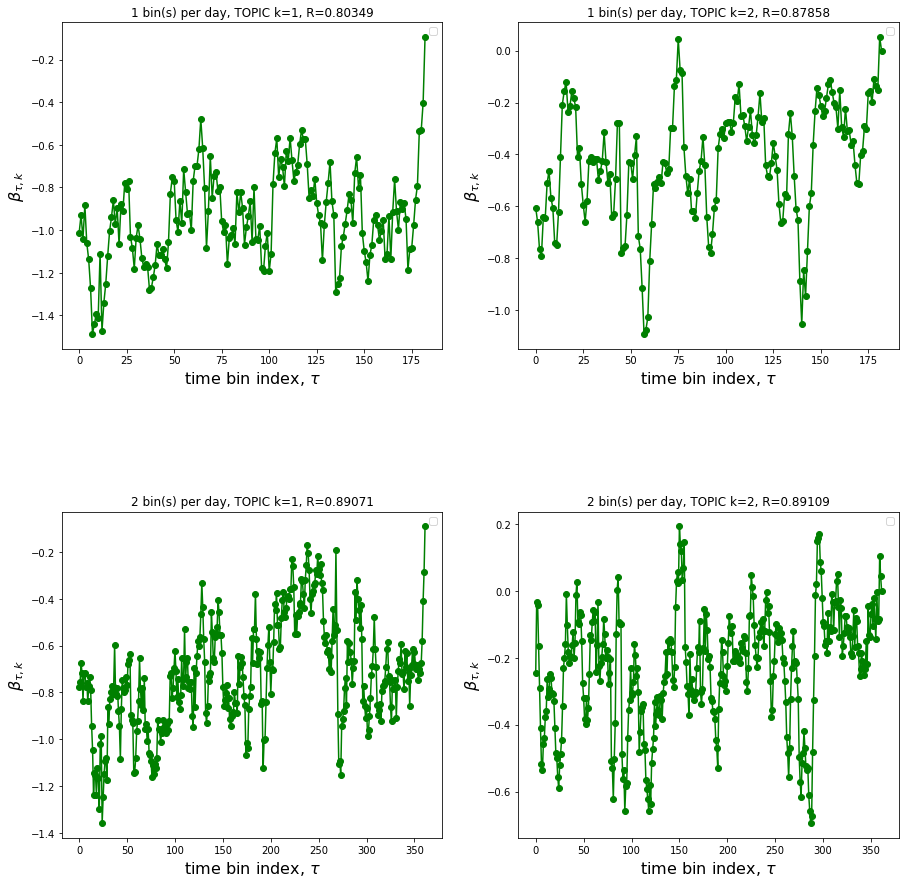

In [16]:
# Logistic regression with the proposed objective
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'s.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(2, 2, j)
        plt.title(str(binc)+' bin(s) per day, TOPIC k='+str(top+1)+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
    
plt.savefig('model_betas_perTopic_proposed.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  25459
25512
183
correlation (binc, topic, autocorrelation): (1, 0, 0.803493) 
183
correlation (binc, topic, autocorrelation): (1, 1, 0.878579) 


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Non-zero features:  43357
43412
362
correlation (binc, topic, autocorrelation): (2, 0, 0.890711) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.891088) 
Non-zero features:  43357
43412
183
correlation (binc, topic, autocorrelation): (2, 0, 0.842256) 
183
correlation (binc, topic, autocorrelation): (2, 1, 0.795762) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.7995575264269742
correlation between 1bin_perday, 2bins_perday, topic 2  0.8060712886082467


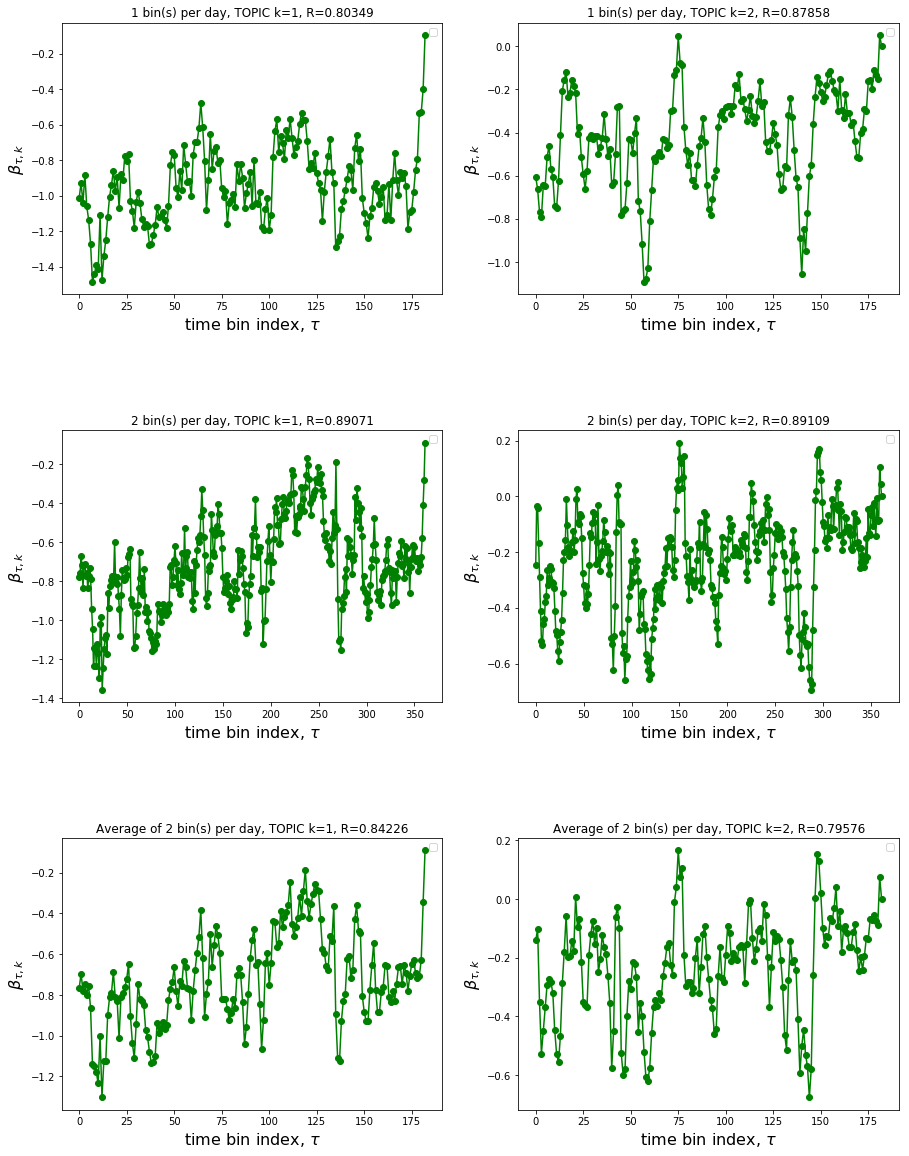

In [17]:
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 20)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    
    res = np.loadtxt('model_parameters_'+str(binc)+'s.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    N = len(res)
    print(N)
    
    no_topics = 100
    topic_time_evt_matrix = res[7212:].flatten().reshape(no_topics, -1)
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix[top]
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            #print(res)
            res = np.mean(res, axis=1)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            per_bin_results.append(res)
        
        print(len(res))
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
    
        plt.subplot(3, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        plt.plot(res, linestyle='-', marker='o', color='g')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    

plt.savefig('model_betas_perTopic_proposed.png', bbox_inches='tight')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


beta_1 parameter (feedback) : 0.2994493005408749
beta_1 parameter std : 0.020831339540292634
183
haha
correlation (binc, topic, autocorrelation): (1, 0, 0.740621) 
183
haha
correlation (binc, topic, autocorrelation): (1, 1, 0.875013) 


No handles with labels found to put in legend.
No handles with labels found to put in legend.


beta_1 parameter (feedback) : 0.2727115826532283
beta_1 parameter std : 0.05083695421080387
362
correlation (binc, topic, autocorrelation): (2, 0, 0.849299) 
362
correlation (binc, topic, autocorrelation): (2, 1, 0.887531) 
beta_1 parameter (feedback) : 0.2727115826532283
beta_1 parameter std : 0.05083695421080387
362
haha
correlation (binc, topic, autocorrelation): (2, 0, 0.782603) 
362
haha
correlation (binc, topic, autocorrelation): (2, 1, 0.794199) 
correlation between 1bin_perday, 2bins_perday, topic 1  0.8959734509852737
correlation between 1bin_perday, 2bins_perday, topic 2  0.9331902219680274


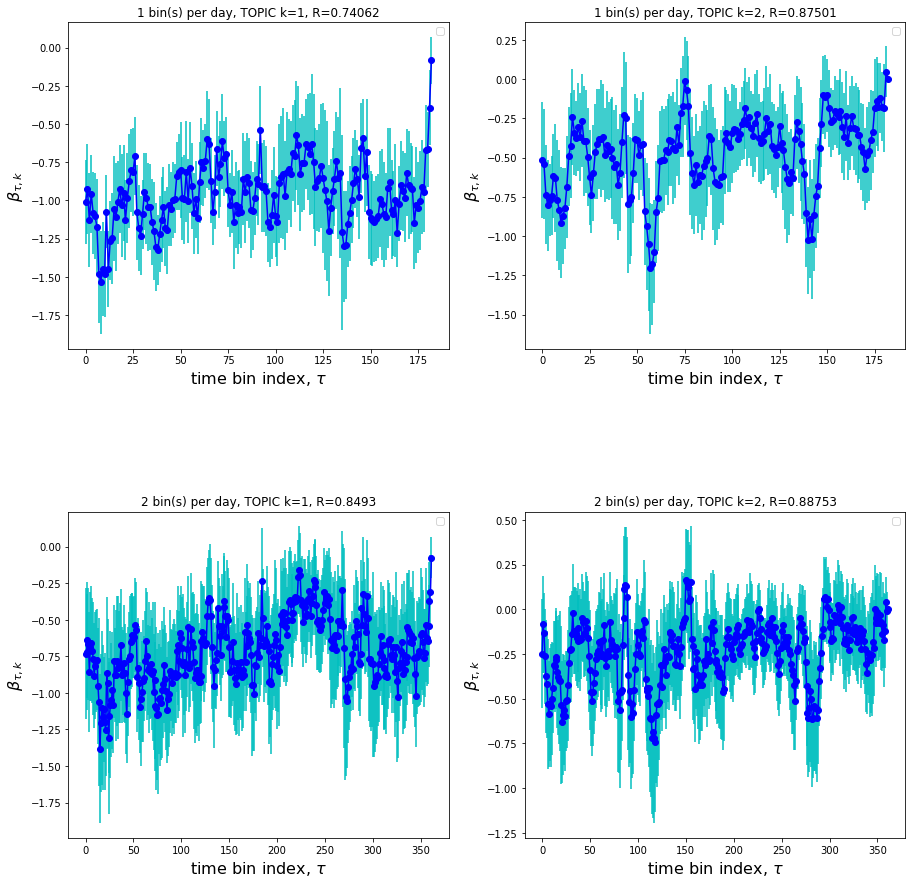

In [21]:
# Logistic regression with the proposed objective (bootstrap)
with open('columnnames.txt', 'r') as f:
    event_colnames = f.readlines()

bin2_indexes = []
for i, colname in enumerate(event_colnames):
    ind = int(colname.strip().split('_')[-1])
    bin2_indexes.append(ind)


exp_bin2_indexes = []
no_2_bins = 2*183  # 183 days in the dataset

absent_indexes = list(set(list(range(no_2_bins))) - set(bin2_indexes))
new_absent_indexes = []
for ind in absent_indexes:
    if ind%2==0:
        ind = ind+1
    else:
        ind = ind-1
    new_absent_indexes.append(ind)
    
bin2_indexes_p = bin2_indexes + new_absent_indexes
bin2_indexes_p = sorted(bin2_indexes_p)

avg_res_bin2 = np.zeros(no_2_bins)
avg_error_bin2 = np.zeros(no_2_bins)


bins_per_day = [1,2, 2]


fig = plt.figure()
fig.subplots_adjust(hspace=.50)
fig.set_size_inches(15, 15)

user_idx = 7212
j=0

per_bin_results = []  # for computing correlation between 1bin per day vs average of 2bins per day
selected_no_topics = 2
for i, binc in enumerate(bins_per_day):
    data = np.loadtxt('model_parameters_'+str(binc)+'boot.txt')
    n_bootstrap = data.shape[0]
    print('beta_1 parameter (feedback) :', np.mean(data[:,0]))
    print('beta_1 parameter std :', 1.96*np.std(data[:,0]))
    
    no_topics = 100
    topic_time_evt_matrix = data[:,7212:].flatten().reshape(n_bootstrap, no_topics, -1)
    
    topic_time_evt_matrix_mean = np.mean(topic_time_evt_matrix, axis=0)
    topic_time_evt_matrix_std = get_standardError(topic_time_evt_matrix)
    #print(topic_time_evt_matrix_std[:10])
    #print(np.std(topic_time_evt_matrix, axis=0)[:10])
    
    
    for top in range(2):
        j+=1
        res = topic_time_evt_matrix_mean[top]
        N = len(res)
        error = topic_time_evt_matrix_std[top]
        print(len(res))
        
        title_name = str(binc)+' bin(s) per day, TOPIC k='+str(top+1)
        if i==2:
            avg_res_bin2[bin2_indexes] = res
            avg_res_bin2[absent_indexes] = avg_res_bin2[new_absent_indexes]
            res = avg_res_bin2.reshape(-1,2)
            res = np.mean(res, axis=1)
            
            avg_error_bin2[bin2_indexes] = error
            avg_error_bin2[absent_indexes] = avg_error_bin2[new_absent_indexes]
            error = avg_error_bin2.reshape(-1,2)
            error = np.mean(error, axis=1)
            
            N = len(res)
            title_name = "Average of "+str(binc) +' bin(s) per day, TOPIC k='+str(top+1)
            
        if i==0 or i==2:
            print("haha")
            per_bin_results.append(res)
            
        
        autocorr = pearsonr(res[:-1], res[1:])[0]
        print('correlation (binc, topic, autocorrelation): (%d, %d, %f) ' %(binc, top, autocorr))

        minr = np.min(res)
        maxr = np.max(res)
        if i==2: continue
        plt.subplot(2, 2, j)
        plt.title(title_name+ ', R='+str(round(autocorr,5)))
        plt.ylabel(r'$\beta_{\tau, k}$', fontsize = 16)
        plt.xlabel('time bin index, 'r'$\tau$', fontsize = 16)
        
        #plt.errorplot(res, linestyle='-', marker='o', color='g')
        plt.errorbar(range(N), res, yerr=error, linestyle='-', color='b', marker='o', ecolor='c')
        #plt.plot([2,2], [minr-2, maxr+2], color='k')
        #plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
        
        plt.legend(loc='best')
    
print('correlation between 1bin_perday, 2bins_perday, topic 1 ', pearsonr(per_bin_results[0], per_bin_results[2])[0])  
print('correlation between 1bin_perday, 2bins_perday, topic 2 ', pearsonr(per_bin_results[1], per_bin_results[3])[0])    
   
plt.savefig('model_betas_perTopic_proposed_boot.png', bbox_inches='tight')

In [19]:
"""l-bfgs-b L1-Logistic Regression solver"""

# Author: Vlad Niculae <vlad@vene.ro>
# Suggested by Mathieu Blondel

from __future__ import division, print_function

import numpy as np
from scipy.optimize import fmin_l_bfgs_b

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.extmath import safe_sparse_dot, log_logistic
#from sklearn.utils.fixes import expit
from scipy.special import expit
from sklearn import grid_search
from scipy.sparse import csr_matrix

        
def _l1_logistic_loss_grad(w_extended, X, y, alpha, k, idx):
    #print(k)
    _, n_features = X.shape
    w = w_extended[:n_features] - w_extended[n_features:]

    yz = y * safe_sparse_dot(X, w)

    # Logistic loss is the negative of the log of the logistic function.
    out = -np.sum(log_logistic(yz))
    # out += .5 * alpha * np.dot(w, w)  # L2
    
    #w_extended[0:2]=0.
    #w_extended[n_features:n_features+2]=0.
    w_ = w[idx:]
    w_= np.transpose(w_.flatten().reshape(k,-1))
    #print(w_.shape)
    D = w_[1:,:]-w_[:-1,:]
    zero = np.zeros((1, k))
    
    D = np.concatenate((D, zero), axis=0)
    D = D.flatten()
    
    #out += alpha * w_extended.sum()
    out += alpha * w_extended.sum() + D.sum() # L1, w_extended is non-negative

    z = expit(yz)
    z0 = (z - 1) * y

    grad = safe_sparse_dot(X.T, z0)
    grad = np.concatenate([grad, -grad])

    # grad += alpha * w  # L2
    #grad += alpha  # L1
    D_grad = np.zeros((n_features,))
    D_grad[idx:] = D
    D_grad = np.concatenate([D_grad, -D_grad])
    grad += alpha + 2*D_grad
    #print(grad.shape)

    return out, grad

class LbfgsL1Logistic(BaseEstimator, ClassifierMixin):

    def __init__(self, tol=1e-3, alpha=1.0):
        """Logistic Regression Lasso solved by L-BFGS-B
        Solves the same objective as sklearn.linear_model.LogisticRegression
        Parameters
        ----------
        alpha: float, default: 1.0
            The amount of regularization to use.
        tol: float, default: 1e-3
            Convergence tolerance for L-BFGS-B.
        """
        self.tol = tol
        self.alpha = alpha

    def fit(self, X, y):
        n_samples, n_features = X.shape
        k = 4
        idx=20

        coef0 = np.zeros(2 * n_features)
        w, f, d = fmin_l_bfgs_b(_l1_logistic_loss_grad, x0=coef0, fprime=None,
                                pgtol=self.tol,
                                bounds=[(0, None)] * n_features * 2,
                                args=(X, y, self.alpha, k, idx))
        self.coef_ = w[:n_features] - w[n_features:]

        return self

    def predict(self, X):
        return np.sign(safe_sparse_dot(X, self.coef_))


if __name__ == '__main__':
    from scipy.spatial.distance import jaccard
    from sklearn.linear_model import LogisticRegression
    from time import time

    # Generate data with known sparsity pattern
    n_samples, n_features, n_relevant = 100, 80, 20
    X = np.random.randn(n_samples, n_features)
    X /= np.linalg.norm(X, axis=1)[:, np.newaxis]
    true_coef = np.zeros(n_features)
    nonzero_idx = np.random.randint(n_features, size=n_relevant)
    true_coef[nonzero_idx] = np.random.randn(n_relevant)
    y = np.dot(X, true_coef) + np.random.randn(n_samples) * 0.01
    # classification, note: y must be {-1, +1}
    
    X = csr_matrix(X)
    y = np.sign(y)    

    C = 1.0
    
    parameters = {'alpha':[0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}
        
    # Run this solver
    t0 = time()
    lasso_1_ = LbfgsL1Logistic(alpha=1. / C, tol=1e-8)
    lasso_1_ = grid_search.GridSearchCV(lasso_1_, parameters)
    lasso_1_.fit(X, y)
    print('')
    lasso_1 = lasso_1_.best_estimator_
    #lasso_1 = LbfgsL1Logistic(alpha=lasso_1_.best_params_['alpha'], tol=1e-8)
    #lasso_1.fit(X, y)
    
    t0 = time() - t0
    print("l-bfgs-b:  time = {:.4f}s acc = {:.8f}  ||w - w_true|| = {:.6f}  "
          "Jacc. sparsity = {:.2f}".format(t0, lasso_1.score(X, y),
            np.linalg.norm(lasso_1.coef_ - true_coef),
            jaccard(true_coef > 0, lasso_1.coef_ > 0)))

    # run liblinear
    t0 = time()
    lasso_2 = LogisticRegression(penalty='l1', C=C, tol=1e-8,
                                 fit_intercept=False).fit( X, y)
    t0 = time() - t0
    print("liblinear: time = {:.4f}s acc = {:.8f}  ||w - w_true|| = {:.6f}  "
          "Jacc. sparsity = {:.2f}".format(t0, lasso_2.score(X, y),
            np.linalg.norm(lasso_2.coef_ - true_coef),
            jaccard(true_coef > 0, lasso_2.coef_ > 0)))


l-bfgs-b:  time = 0.1598s acc = 0.91000000  ||w - w_true|| = 4.352475  Jacc. sparsity = 0.57
liblinear: time = 0.0011s acc = 0.91000000  ||w - w_true|| = 4.917182  Jacc. sparsity = 0.44


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


\begin{equation}
y_i = \sigma \left(\alpha_1 T_i + \alpha_2 \Delta t_i + \sum_{\tau=0}^{B}  \sum_{k=0}^{100} \delta_{\tau_i \tau} \delta_{k_i k}  \beta_{\tau k} + \sum_{k=0}^{100} \gamma_k \delta_{k k_i} \right)
\label{eq:model_logit}
\end{equation}

No handles with labels found to put in legend.


Non-zero features:  18347


No handles with labels found to put in legend.


Non-zero features:  30294


No handles with labels found to put in legend.


Non-zero features:  44413


No handles with labels found to put in legend.


Non-zero features:  56761


No handles with labels found to put in legend.


Non-zero features:  74270


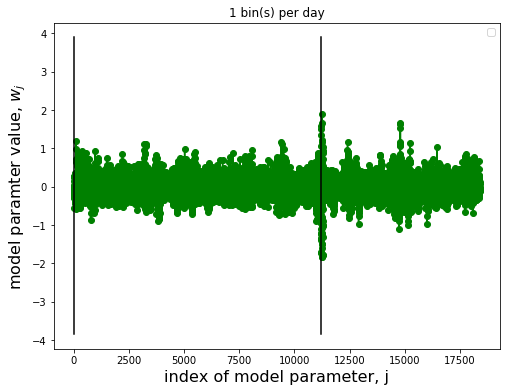

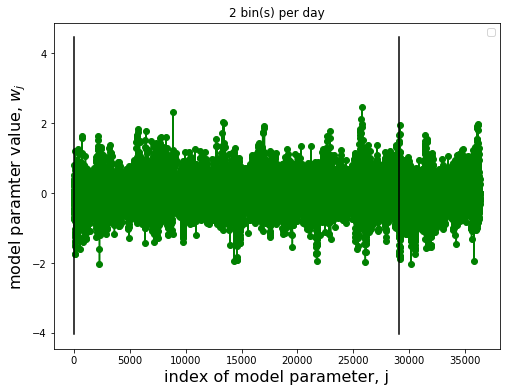

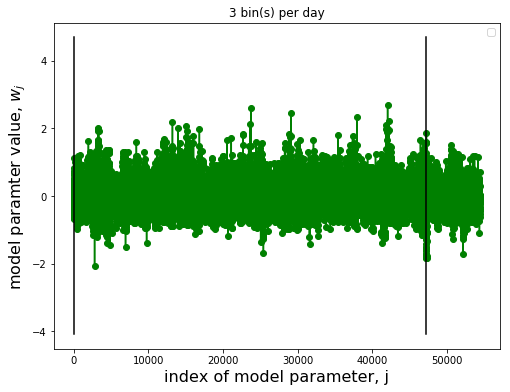

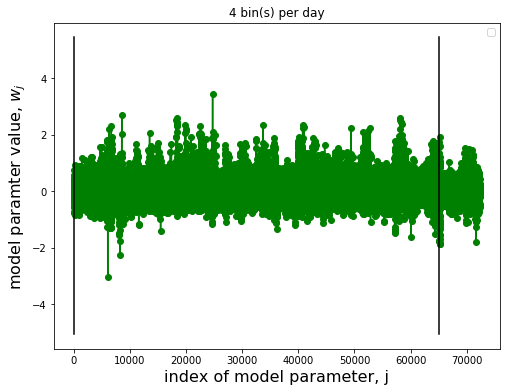

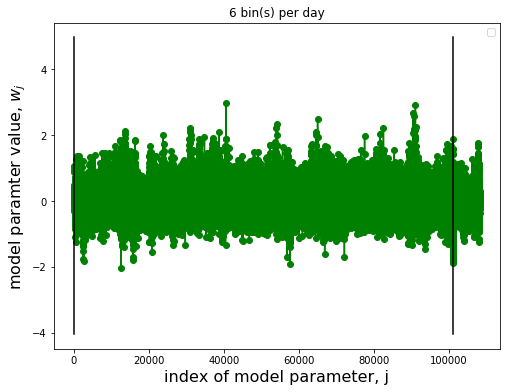

In [22]:
# Proposed Objective function
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

user_idx = 7212
for binc in bins_per_day:
    res = np.loadtxt('model_parameters_'+str(binc)+'t.txt')
    print('Non-zero features: ', len(np.where(res!=0)[0]))
    resA = res[user_idx:]
    resB = res[2:user_idx]
    res = np.concatenate((res[:2], resA, resB))
    N = len(res)
    
    minr = np.min(res)
    maxr = np.max(res)
    
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.title(str(binc)+' bin(s) per day')

    plt.plot(res, linestyle='-', marker='o', color='g')
    plt.plot([2,2], [minr-2, maxr+2], color='k')
    plt.plot([N-user_idx,N-user_idx], [minr-2, maxr+2], color='k')
    plt.ylabel('model paramter value, ' r'$w_j$', fontsize = 16)
    plt.xlabel('index of model parameter, 'r'j', fontsize = 16)
    plt.legend(loc='best')
    plt.savefig('model_betas_'+str(binc)+'mbins_per_day_topic.png', bbox_inches='tight')

In [ ]:
# Proposed Objective function: beta_1 value (topic control)
import matplotlib.pyplot as plt
import numpy as np

bins_per_day = [1,2,3,4,6]

res_base = np.loadtxt('model_parameters_bsplit.txt')

betas_1 = []
std_errors = []
baseline =  res_base[0]               
for binc in bins_per_day:
    data = np.loadtxt('model_parameters_'+str(binc)+'t_boot.txt')
    res = np.mean(data[:,0])
    betas_1.append(res)
    error = get_standardError(data[:,0]) 
    std_errors.append(error)

print(betas_1)
fig = plt.figure()
fig.set_size_inches(8, 6)
plt.title('Proposed Objective function: Fitted value for Feedback')

plt.errorbar(bins_per_day, betas_1, yerr = std_errors, linestyle='-', marker='o', color='g', label='with modeling events')
plt.plot(bins_per_day, [baseline]*len(bins_per_day),  marker='o', color='b', label='without modeling events')
plt.xlabel('Number of bins per day', fontsize = 16)
plt.ylabel('feedback, ' r' $\alpha_1$', fontsize = 16)
plt.legend(loc='best')
plt.savefig('model_betas_M2_topic.png', bbox_inches='tight')